In [1]:
import json
import math
import re
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from tqdm.auto import tqdm


In [2]:
ARTIFACT_DIR = Path('artifacts')
ARTIFACT_DIR.mkdir(exist_ok=True)
LOG_FILE = ARTIFACT_DIR / 'training.log'
LOG_FILE.touch(exist_ok=True)

def log_message(message):
    timestamp = pd.Timestamp.utcnow().isoformat()
    line = f'[{timestamp}] {message}'
    print(line)
    with open(LOG_FILE, 'a') as fh:
        fh.write(line + '\n')


In [3]:
def calculate_sharpe(pnl_series):
    std = pnl_series.std()
    if std == 0:
        return 0.0
    return pnl_series.mean() / std


## Load data

In [4]:

DATA_PATH = Path('../autodl-tmp/final_df.csv')
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Cannot find {DATA_PATH}")

df_ori = pd.read_csv(DATA_PATH)
df = df_ori.copy()
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(['symbol', 'datetime']).reset_index(drop=True)

symbol_list = sorted(df['symbol'].unique())
symbol_to_id = {sym: idx for idx, sym in enumerate(symbol_list)}
df['symbol_id'] = df['symbol'].map(symbol_to_id).astype(np.int64)
NUM_SYMBOLS = len(symbol_list)
print(f"Loaded {NUM_SYMBOLS} symbols: {symbol_list}")

df['lret_1m'] = df.groupby('symbol')['close'].transform(lambda s: np.log(s).diff())
df['y_target'] = df.groupby('symbol')['lret_1m'].shift(-1)

initial_rows = len(df)
df = df[df['y_target'].abs() <= 0.2].dropna(subset=['y_target', 'lret_1m'])
df = df.sort_values(['datetime', 'symbol']).reset_index(drop=True)
print(f"Dropped {initial_rows - len(df)} rows with abnormal/NaN targets")
print(df[['datetime', 'symbol', 'close', 'lret_1m', 'y_target']].head())


Loaded 5 symbols: ['AMAT', 'AMD', 'AVGO', 'MU', 'NVDA']
Dropped 12 rows with abnormal/NaN targets
             datetime symbol      close   lret_1m  y_target
0 2024-04-30 12:51:00   AMAT  200.51000 -0.000199 -0.000100
1 2024-04-30 12:51:00    AMD  159.36000  0.000314 -0.000126
2 2024-04-30 12:51:00   AVGO  131.65200 -0.000334  0.000721
3 2024-04-30 12:51:00     MU  114.58000  0.000698 -0.000698
4 2024-04-30 12:51:00   NVDA   86.89927 -0.000769 -0.000907


In [7]:
# print the length of the dataframe
print(f"Dataframe length: {len(df)}")

Dataframe length: 324888


In [8]:
# sum the number of unique minutes per day
minutes_per_day = (
    df.assign(minute = df['datetime'].dt.floor('min'))
      .groupby(df['datetime'].dt.date)['minute']
      .nunique()
      .sort_index()
)

print("每个日期的不同分钟数（按分钟聚合）:")
print(minutes_per_day)

print("\n汇总统计:")
print(minutes_per_day.describe())

每个日期的不同分钟数（按分钟聚合）:
datetime
2024-04-30    189
2024-05-01    190
2024-05-02    190
2024-05-03    190
2024-05-06    190
             ... 
2025-10-22    190
2025-10-23    190
2025-10-24    190
2025-10-27    190
2025-10-28    189
Name: minute, Length: 342, dtype: int64

汇总统计:
count    342.000000
mean     189.994152
std        0.076360
min      189.000000
25%      190.000000
50%      190.000000
75%      190.000000
max      190.000000
Name: minute, dtype: float64


## Feature cleaning

In [9]:
y = df['y_target']
X = df.drop(columns=[
    'y_target', 'lret_1m', 'datetime', 'symbol',
    'year', 'month', 'day', 'minute', 'minute_of_day'
], errors='ignore')
print(f"Original feature shape: {X.shape}")

SPARSE_ZERO_THRESHOLD = 0.9
LOW_CARDINALITY_THRESHOLD = 20
MISSING_EMB_THRESHOLD = 0.3
EMBED_MAX_BINS = 16

missing_ratio = X.isna().mean()
embedding_source_cols = missing_ratio[missing_ratio >= MISSING_EMB_THRESHOLD].index.tolist()
embedding_feature_cols = []
embedding_meta = {}
embedding_bin_df = pd.DataFrame(index=X.index)


def _build_bin_edges(series, max_bins=EMBED_MAX_BINS):
    non_na = series.dropna()
    if non_na.empty:
        return np.array([0.0, 1.0], dtype=float)
    unique_vals = non_na.nunique()
    if unique_vals == 1:
        val = float(non_na.iloc[0])
        return np.array([val - 1e-6, val + 1e-6], dtype=float)
    quantiles = np.linspace(0, 1, min(max_bins, unique_vals) + 1)
    edges = np.quantile(non_na, quantiles)
    edges = np.unique(edges)
    if len(edges) == 1:
        edges = np.array([edges[0] - 1e-6, edges[0] + 1e-6], dtype=float)
    return edges


for col in embedding_source_cols:
    edges = _build_bin_edges(X[col])
    bins = edges[1:-1]
    bin_idx = pd.Series(0, index=X.index, dtype=np.int64)
    non_na = X[col].dropna()
    if not non_na.empty:
        if len(bins) == 0:
            encoded = pd.Series(1, index=non_na.index, dtype=np.int64)
        else:
            encoded = pd.Series(np.digitize(non_na, bins, right=False) + 1, index=non_na.index)
        bin_idx.loc[encoded.index] = encoded.astype(np.int64)
    emb_col = f"{col}_emb_bin"
    embedding_bin_df[emb_col] = bin_idx.values
    embedding_feature_cols.append(emb_col)
    embedding_meta[emb_col] = {
        'source': col,
        'num_bins': int(len(edges) - 1)
    }

X_rest = X.drop(columns=embedding_source_cols, errors='ignore')

numeric_cols = X_rest.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_cols = [c for c in X_rest.columns if c not in numeric_cols]
zero_share = (X_rest[numeric_cols] == 0).sum(axis=0) / len(X_rest) if numeric_cols else pd.Series(dtype=float)
sparse_numeric = zero_share[zero_share >= SPARSE_ZERO_THRESHOLD].index.tolist()
low_card_numeric = [c for c in numeric_cols if X_rest[c].nunique(dropna=True) <= LOW_CARDINALITY_THRESHOLD]

freq_cols = sorted(set(non_numeric_cols + sparse_numeric + low_card_numeric))
freq_encoded_df = pd.DataFrame(index=X_rest.index)
freq_maps = {}
for col in freq_cols:
    if col not in X_rest.columns:
        continue
    series = X_rest[col].fillna('__MISSING__')
    freqs = series.value_counts(normalize=True)
    freq_encoded_df[f"{col}_freq"] = series.map(freqs).astype(np.float32)
    freq_maps[col] = freqs.to_dict()

X_rest = X_rest.drop(columns=[c for c in freq_cols if c in X_rest.columns], errors='ignore')
X_enhanced = pd.concat([X_rest, freq_encoded_df, embedding_bin_df], axis=1)

value_feature_cols = [c for c in X_enhanced.columns if c not in embedding_feature_cols]
X_cleaned = X_enhanced[value_feature_cols + embedding_feature_cols]
print(f"Value feature count: {len(value_feature_cols)} | Embedding features: {len(embedding_feature_cols)}")


Original feature shape: (324888, 185)
Value feature count: 185 | Embedding features: 0


## Train / test split

In [10]:
split_ratio = 1.0 / 1.5
split_index = int(len(X_cleaned) * split_ratio)

X_train = X_cleaned.iloc[:split_index]
y_train = y.iloc[:split_index]
X_test = X_cleaned.iloc[split_index:]
y_test = y.iloc[split_index:]

print(f"Train shape: {X_train.shape}")
print(f"Test shape:  {X_test.shape}")


Train shape: (216592, 185)
Test shape:  (108296, 185)


## Preprocessing pipeline

Same as in LASSO, ridge regression notebook

In [11]:
class QuantileClipper(BaseEstimator, TransformerMixin):
    def __init__(self, lower=0.01, upper=0.99):
        self.lower = lower
        self.upper = upper
        self.q_low_ = None
        self.q_high_ = None

    def fit(self, X, y=None):
        self.q_low_ = np.nanpercentile(X, self.lower * 100, axis=0)
        self.q_high_ = np.nanpercentile(X, self.upper * 100, axis=0)
        return self

    def transform(self, X):
        return np.clip(X, self.q_low_, self.q_high_)

def split_columns_for_scaling(X):
    patterns = [
        r'^fz_', r'_z_', r'(?:^|_)tanh', r'(?:^|_)arctanh',
        r'(?:^|_)sin$', r'(?:^|_)cos$', r'^dow_\d+$',
        r'^has_news$', r'(?:^|_)log', r'(?:^|_)ln', r'(?:^|_)ewm',
        r'^tone_', r'_flag$', r'_iqr_outlier$'
    ]
    regex = re.compile('|'.join(patterns))
    name_matched = [c for c in X.columns if regex.search(c)]
    binary_cols = [c for c in X.columns if X[c].nunique(dropna=True) <= 2]
    no_scale_cols = sorted(set(name_matched + binary_cols))
    scale_cols = [c for c in X.columns if c not in no_scale_cols]
    return no_scale_cols, scale_cols

value_df = X_cleaned[value_feature_cols].copy()
no_scale_cols, scale_cols = split_columns_for_scaling(value_df)

raw_branch_pipeline = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('winsor', QuantileClipper(lower=0.01, upper=0.99)),
    ('scale', MaxAbsScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('raw_scaler', raw_branch_pipeline, scale_cols),
        ('passthrough_features', 'passthrough', no_scale_cols),
    ],
    remainder='drop'
)

numeric_processed = preprocessor.fit_transform(value_df)
feature_cols = scale_cols + no_scale_cols
numeric_df = pd.DataFrame(numeric_processed, columns=feature_cols, index=value_df.index)

if embedding_feature_cols:
    embedding_df = X_cleaned[embedding_feature_cols].astype(np.int64)
    X_all_processed = pd.concat([numeric_df, embedding_df], axis=1)
else:
    embedding_df = pd.DataFrame(index=value_df.index)
    X_all_processed = numeric_df

embedding_cardinalities = [
    int(embedding_meta[col]['num_bins'] + 1)
    for col in embedding_feature_cols
]

print(
    f"Preprocessing complete | numeric features: {len(feature_cols)}, "
    f"embedding features: {len(embedding_feature_cols)}"
)


Preprocessing complete | numeric features: 185, embedding features: 0


### Feature preprocessing parity
We mirror the LASSO notebook by splitting raw vs. pre-engineered features via regex, applying QuantileClipper + MaxAbsScaler only to the raw branch, and passthrough everything else. A median imputer is kept before clipping so tensor batches never contain NaNs when fed into PyTorch.


In [12]:
df_processed = X_all_processed.copy()
df_processed[['datetime', 'symbol', 'symbol_id', 'y_target']] = df[['datetime', 'symbol', 'symbol_id', 'y_target']].values

train_df = df_processed.iloc[:split_index].copy()
test_df = df_processed.iloc[split_index:].copy()

In [13]:
# print descriptive statistics for train and test sets
print("statistics for train and test sets:")
print(train_df.describe().T)
print("statistics for train and test sets:")
print(test_df.describe().T)

statistics for train and test sets:


                  count                           mean                  min  \
f_minsin       216592.0                      -0.667036                 -1.0   
f_mincos       216592.0                      -0.802896                 -1.0   
close          216592.0                       0.423201             0.228642   
f_volume_norm  216592.0                       0.019932            -0.207585   
high           216592.0                        0.42321             0.228691   
...                 ...                            ...                  ...   
volu_z_15      216592.0                        0.16572            -2.804441   
volu_z_30      216592.0                       0.245106            -2.965688   
volu_z_5       216592.0                       0.063102             -1.78767   
volu_z_60      216592.0                       0.320376            -3.015014   
datetime         216592  2024-10-28 18:08:50.760046848  2024-04-30 12:51:00   

                               25%                 

## Sequence construction

In [14]:
SEQ_LEN = 30
PRED_HORIZON = 1


def build_sequences(dataframe, numeric_cols, embedding_cols, target_col, seq_len=SEQ_LEN):
    X_seq, X_emb_seq, y_seq, meta_dt, symbol_ids = [], [], [], [], []
    has_embeddings = len(embedding_cols) > 0
    for symbol, group in dataframe.groupby('symbol'):
        group = group.sort_values('datetime')
        feats = group[numeric_cols].values.astype(np.float32)
        emb_feats = group[embedding_cols].values.astype(np.int64) if has_embeddings else None
        target = group[target_col].values
        dts = group['datetime'].values
        symbol_id = group['symbol_id'].iloc[0]
        for i in range(len(group) - seq_len - PRED_HORIZON + 1):
            start = i
            end = i + seq_len
            target_idx = end + PRED_HORIZON - 1
            X_seq.append(feats[start:end])
            if has_embeddings:
                X_emb_seq.append(emb_feats[start:end])
            y_seq.append(target[target_idx])
            meta_dt.append(dts[target_idx])
            symbol_ids.append(symbol_id)
    if not X_seq:
        raise RuntimeError('Sequence construction produced zero samples; check SEQ_LEN/PRED_HORIZON.')
    X_seq = np.array(X_seq, dtype=np.float32)
    if has_embeddings:
        X_emb_seq = np.array(X_emb_seq, dtype=np.int64)
    else:
        X_emb_seq = np.zeros((len(X_seq), seq_len, 0), dtype=np.int64)
    return (
        X_seq,
        X_emb_seq,
        np.array(y_seq, dtype=np.float32),
        np.array(meta_dt),
        np.array(symbol_ids, dtype=np.int64)
    )

train_X_seq, train_emb_seq, train_y_seq, train_meta_dt, train_symbol_ids = build_sequences(
    train_df, feature_cols, embedding_feature_cols, 'y_target', seq_len=SEQ_LEN
)

test_X_seq, test_emb_seq, test_y_seq, test_meta_dt, test_symbol_ids = build_sequences(
    test_df, feature_cols, embedding_feature_cols, 'y_target', seq_len=SEQ_LEN
)

print(f"Train sequences: {train_X_seq.shape} | Embeddings: {train_emb_seq.shape}")
print(f"Test sequences:  {test_X_seq.shape} | Embeddings: {test_emb_seq.shape}")


Train sequences: (216442, 30, 185) | Embeddings: (216442, 30, 0)
Test sequences:  (108146, 30, 185) | Embeddings: (108146, 30, 0)


In [15]:
train_order = np.argsort(train_meta_dt)
train_X_seq = train_X_seq[train_order]
train_emb_seq = train_emb_seq[train_order]
train_y_seq = train_y_seq[train_order]
train_meta_dt = train_meta_dt[train_order]
train_symbol_ids = train_symbol_ids[train_order]

test_order = np.argsort(test_meta_dt)
test_X_seq = test_X_seq[test_order]
test_emb_seq = test_emb_seq[test_order]
test_y_seq = test_y_seq[test_order]
test_meta_dt = test_meta_dt[test_order]
test_symbol_ids = test_symbol_ids[test_order]


In [16]:
y_scaler = StandardScaler()
train_y_seq_raw = train_y_seq.copy()
test_y_seq_raw = test_y_seq.copy()

train_y_seq = y_scaler.fit_transform(train_y_seq.reshape(-1, 1)).astype(np.float32).ravel()
test_y_seq = y_scaler.transform(test_y_seq.reshape(-1, 1)).astype(np.float32).ravel()


## Prefix K-fold DataLoaders

In [17]:
BATCH_SIZE = 256
PURGE_GAP_MINUTES = 60
EMBARGO_GAP_MINUTES = 30


def _apply_purge_embargo(train_idx, val_idx, meta_dt, purge_minutes, embargo_minutes):
    train_times = meta_dt[train_idx]
    val_times = meta_dt[val_idx]
    if len(train_times) == 0 or len(val_times) == 0:
        return train_idx, val_idx
    purge_cutoff = train_times.max() + np.timedelta64(purge_minutes, 'm')
    val_mask = val_times > purge_cutoff
    if not val_mask.any():
        val_mask = np.ones_like(val_idx, dtype=bool)
    embargo_cutoff = val_times.min() - np.timedelta64(embargo_minutes, 'm')
    train_mask = train_times < embargo_cutoff
    if not train_mask.any():
        train_mask = np.ones_like(train_idx, dtype=bool)
    return train_idx[train_mask], val_idx[val_mask]


def create_prefix_folds(
    X_seq,
    X_emb_seq,
    symbol_ids,
    y_scaled_seq,
    y_raw_seq,
    meta_dt,
    n_splits=10,
    batch_size=BATCH_SIZE,
    purge_minutes=PURGE_GAP_MINUTES,
    embargo_minutes=EMBARGO_GAP_MINUTES
):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    folds = []
    fold_meta = []
    for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(X_seq), start=1):
        train_idx_adj, val_idx_adj = _apply_purge_embargo(train_idx, val_idx, meta_dt, purge_minutes, embargo_minutes)
        if len(train_idx_adj) == 0 or len(val_idx_adj) == 0:
            train_idx_adj, val_idx_adj = train_idx, val_idx
        X_tr, X_va = X_seq[train_idx_adj], X_seq[val_idx_adj]
        X_emb_tr, X_emb_va = X_emb_seq[train_idx_adj], X_emb_seq[val_idx_adj]
        sym_tr, sym_va = symbol_ids[train_idx_adj], symbol_ids[val_idx_adj]
        y_scaled_tr, y_scaled_va = y_scaled_seq[train_idx_adj], y_scaled_seq[val_idx_adj]
        y_raw_tr, y_raw_va = y_raw_seq[train_idx_adj], y_raw_seq[val_idx_adj]

        train_ds = TensorDataset(
            torch.from_numpy(X_tr),
            torch.from_numpy(X_emb_tr),
            torch.from_numpy(sym_tr),
            torch.from_numpy(y_scaled_tr),
            torch.from_numpy(y_raw_tr)
        )
        val_ds = TensorDataset(
            torch.from_numpy(X_va),
            torch.from_numpy(X_emb_va),
            torch.from_numpy(sym_va),
            torch.from_numpy(y_scaled_va),
            torch.from_numpy(y_raw_va)
        )
        folds.append((
            DataLoader(train_ds, batch_size=batch_size, shuffle=True),
            DataLoader(val_ds, batch_size=batch_size, shuffle=False)
        ))
        fold_meta.append({
            'fold': fold_idx,
            'train_end': meta_dt[train_idx_adj].max(),
            'val_end': meta_dt[val_idx_adj].max()
        })
        log_message(
            f"Fold {fold_idx}: train {len(train_ds)} seq, val {len(val_ds)} seq | "
            f"train_idx {train_idx_adj[0]}-{train_idx_adj[-1]}"
        )
    return folds, fold_meta

prefix_folds, fold_time_meta = create_prefix_folds(
    train_X_seq,
    train_emb_seq,
    train_symbol_ids,
    train_y_seq,
    train_y_seq_raw,
    train_meta_dt,
    n_splits=10
)


[2025-11-10T00:09:48.813697+00:00] Fold 1: train 19530 seq, val 19563 seq | train_idx 0-19529
[2025-11-10T00:09:49.447496+00:00] Fold 2: train 39205 seq, val 19374 seq | train_idx 0-39204
[2025-11-10T00:09:50.241468+00:00] Fold 3: train 58880 seq, val 19375 seq | train_idx 0-58879
[2025-11-10T00:09:51.278047+00:00] Fold 4: train 78695 seq, val 19376 seq | train_idx 0-78694
[2025-11-10T00:09:52.531889+00:00] Fold 5: train 98235 seq, val 19417 seq | train_idx 0-98234
[2025-11-10T00:09:53.959323+00:00] Fold 6: train 117910 seq, val 19373 seq | train_idx 0-117909
[2025-11-10T00:09:55.628283+00:00] Fold 7: train 137594 seq, val 19375 seq | train_idx 0-137593
[2025-11-10T00:09:57.547943+00:00] Fold 8: train 157264 seq, val 19546 seq | train_idx 0-157263
[2025-11-10T00:09:59.711439+00:00] Fold 9: train 176939 seq, val 19372 seq | train_idx 0-176938
[2025-11-10T00:10:02.068366+00:00] Fold 10: train 196614 seq, val 19373 seq | train_idx 0-196613


In [18]:
# Global experiment / logging config
ARTIFACT_DIR = Path('artifacts')
ARTIFACT_DIR.mkdir(exist_ok=True)
LOG_FILE = ARTIFACT_DIR / 'training.log'
LOG_FILE.touch(exist_ok=True)

CV_SHARPE_THRESHOLD = 0.0
CV_MAX_FOLDS = 6
HUBER_DELTA = 5e-4
DEFAULT_WARMUP_EPOCHS = 5
ROLLING_STEP_MINUTES = 30
TOP_K = 5
POSITION_SCALE = 1e-3


def log_message(message):
    timestamp = pd.Timestamp.utcnow().isoformat()
    line = f"[{timestamp}] {message}"
    print(line)
    with open(LOG_FILE, 'a') as fh:
        fh.write(line + '')


## Transformer model

In [ ]:
class ReturnTransformer(nn.Module):
    def __init__(
        self,
        feature_dim,
        num_symbols,
        embedding_cardinalities=None,
        symbol_emb_dim=8,
        categorical_emb_dim=8,
        d_model=128,
        nhead=4,
        num_layers=2,
        ff_dim=384,
        dropout=0.3
    ):
        super().__init__()
        # Embedding layers for 5 categorical features
        self.embedding_cardinalities = embedding_cardinalities or []
        self.categorical_embs = nn.ModuleList([
            nn.Embedding(cardinality, categorical_emb_dim)
            for cardinality in self.embedding_cardinalities
        ])
        cat_dim = categorical_emb_dim * len(self.categorical_embs)
        # Embedding layer for symbol IDs
        self.symbol_emb = nn.Embedding(num_symbols, symbol_emb_dim)
        self.pre_proj_dim = feature_dim + cat_dim + symbol_emb_dim
        self.pre_layer_norm = nn.LayerNorm(self.pre_proj_dim)
        self.input_proj = nn.Linear(self.pre_proj_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True,
            activation='gelu',
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.post_layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.head = nn.Linear(d_model, 1)

    def forward(self, x_numeric, symbol_ids, categorical_ids=None):
        cat_chunks = []
        if categorical_ids is not None and categorical_ids.shape[-1] == len(self.categorical_embs):
            for idx, emb in enumerate(self.categorical_embs):
                cat_chunks.append(emb(categorical_ids[..., idx]))
        if cat_chunks:
            cat_emb = torch.cat(cat_chunks, dim=-1)
        else:
            cat_emb = x_numeric.new_zeros(x_numeric.size(0), x_numeric.size(1), 0)
        sym_emb = self.symbol_emb(symbol_ids).unsqueeze(1).expand(-1, x_numeric.size(1), -1)
        x = torch.cat([x_numeric, cat_emb, sym_emb], dim=-1)
        x = self.input_proj(self.pre_layer_norm(x))
        encoded = self.encoder(x)
        encoded = self.post_layer_norm(encoded)
        pooled = encoded[:, -1, :]
        return self.head(self.dropout(pooled)).squeeze(-1)


## Training utilities

In [20]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class WarmupCosineScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_epochs, max_epochs, min_lr=1e-5):
        self.warmup_epochs = max(1, warmup_epochs)
        self.max_epochs = max_epochs
        self.min_lr = min_lr
        super().__init__(optimizer)

    def get_lr(self):
        epoch = self.last_epoch + 1
        if epoch <= self.warmup_epochs:
            scale = epoch / self.warmup_epochs
            return [base_lr * scale for base_lr in self.base_lrs]
        progress = (epoch - self.warmup_epochs) / max(1, self.max_epochs - self.warmup_epochs)
        cosine = 0.5 * (1 + math.cos(math.pi * progress))
        return [self.min_lr + (base_lr - self.min_lr) * cosine for base_lr in self.base_lrs]


def _maybe_cat_embeddings(x_emb):
    if x_emb is None:
        return None
    if x_emb.dim() == 3 and x_emb.size(-1) == 0:
        return None
    return x_emb


def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for xb, xemb, symb, yb_scaled, _ in loader:
        xb = xb.to(DEVICE)
        xemb = xemb.to(DEVICE)
        symb = symb.to(DEVICE)
        yb_scaled = yb_scaled.to(DEVICE)
        optimizer.zero_grad()
        preds = model(xb, symb, _maybe_cat_embeddings(xemb))
        loss = criterion(preds, yb_scaled)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item() * len(xb)
    return total_loss / len(loader.dataset)


def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for xb, xemb, symb, yb_scaled, _ in loader:
            xb = xb.to(DEVICE)
            xemb = xemb.to(DEVICE)
            symb = symb.to(DEVICE)
            yb_scaled = yb_scaled.to(DEVICE)
            preds = model(xb, symb, _maybe_cat_embeddings(xemb))
            loss = criterion(preds, yb_scaled)
            total_loss += loss.item() * len(xb)
    return total_loss / len(loader.dataset)


def predict_batches(model, X_array, X_emb_array, symbol_ids, batch_size=512):
    model.eval()
    preds = []
    with torch.no_grad():
        for start in range(0, len(X_array), batch_size):
            end = start + batch_size
            xb = torch.from_numpy(X_array[start:end]).to(DEVICE)
            xemb = torch.from_numpy(X_emb_array[start:end]).to(DEVICE)
            symb = torch.from_numpy(symbol_ids[start:end]).to(DEVICE)
            preds.append(model(xb, symb, _maybe_cat_embeddings(xemb)).cpu().numpy())
    return np.concatenate(preds)


In [21]:
def map_to_position(pred_returns, scale=POSITION_SCALE):
    if scale <= 0:
        return pred_returns
    return np.tanh(pred_returns / scale)


def compute_regression_metrics(pred_returns, actual_returns):
    diff = pred_returns - actual_returns
    rmse = float(np.sqrt(np.mean(diff ** 2)))
    mae = float(np.mean(np.abs(diff)))
    pnl = pd.Series(map_to_position(pred_returns) * actual_returns)
    sharpe = calculate_sharpe(pnl)
    pred_series = pd.Series(pred_returns)
    actual_series = pd.Series(actual_returns)
    pearson_ic = pred_series.corr(actual_series)
    spearman_ic = pred_series.corr(actual_series, method='spearman')
    return {
        'rmse': rmse,
        'mae': mae,
        'sharpe': float(sharpe),
        'ic_pearson': float(pearson_ic) if pearson_ic is not None else np.nan,
        'ic_spearman': float(spearman_ic) if spearman_ic is not None else np.nan
    }


In [22]:
def evaluate_loader_metrics(model, loader, scaler):
    model.eval()
    pred_scaled, actual_raw = [], []
    with torch.no_grad():
        for xb, xemb, symb, _, yb_raw in loader:
            xb = xb.to(DEVICE)
            xemb = xemb.to(DEVICE)
            symb = symb.to(DEVICE)
            preds = model(xb, symb, _maybe_cat_embeddings(xemb)).cpu().numpy()
            pred_scaled.append(preds)
            actual_raw.append(yb_raw.numpy())
    pred_scaled = np.concatenate(pred_scaled)
    actual_raw = np.concatenate(actual_raw)
    pred_raw = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()
    return compute_regression_metrics(pred_raw, actual_raw)


In [23]:
def evaluate_sharpe(model, loader, scaler):
    model.eval()
    preds_list, rets_list = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            preds = model(xb).cpu().numpy()
            rets = yb.cpu().numpy()
            preds_raw = scaler.inverse_transform(preds.reshape(-1, 1)).ravel()
            rets_raw = scaler.inverse_transform(rets.reshape(-1, 1)).ravel()
            preds_list.append(preds_raw)
            rets_list.append(rets_raw)
    preds = np.concatenate(preds_list)
    rets = np.concatenate(rets_list)
    return calculate_sharpe(pd.Series(preds * rets))


## Prefix CV training

In [25]:
import copy

def fit_with_prefix_cv(
    folds,
    feature_dim,
    num_symbols,
    embedding_cardinalities,
    target_scaler,
    model_kwargs=None,
    epochs=60,
    lr=5e-4,
    weight_decay=1e-3,
    patience=6,
    warmup_epochs=DEFAULT_WARMUP_EPOCHS,
):
    model_kwargs = model_kwargs or {}
    histories = []
    best_states = []
    criterion = nn.SmoothL1Loss(beta=HUBER_DELTA)
    for fold_idx, (train_loader, val_loader) in enumerate(folds, start=1):
        model = ReturnTransformer(
            feature_dim,
            num_symbols,
            embedding_cardinalities=embedding_cardinalities,
            **model_kwargs
        ).to(DEVICE)
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = WarmupCosineScheduler(optimizer, warmup_epochs, epochs, min_lr=1e-5)
        best_val = math.inf
        best_sharpe = -math.inf
        best_state = None
        patience_ctr = 0
        fold_curve = []

        for epoch in range(1, epochs + 1):
            train_loss = train_epoch(model, train_loader, optimizer, criterion)
            val_loss = eval_epoch(model, val_loader, criterion)
            val_metrics = evaluate_loader_metrics(model, val_loader, target_scaler)
            fold_curve.append({
                'fold': fold_idx,
                'epoch': epoch,
                'train_loss': float(train_loss),
                'val_loss': float(val_loss),
                'val_sharpe': val_metrics['sharpe'],
                'val_rmse': val_metrics['rmse']
            })
            improved = False
            if val_loss < best_val - 1e-6:
                improved = True
            elif abs(val_loss - best_val) <= 1e-6 and val_metrics['sharpe'] > best_sharpe + 1e-4:
                improved = True
            if improved:
                best_val = val_loss
                best_sharpe = val_metrics['sharpe']
                best_state = copy.deepcopy(model.state_dict())
                patience_ctr = 0
            else:
                patience_ctr += 1
            scheduler.step()
            log_message(
                f"Fold {fold_idx} | Epoch {epoch} | train {train_loss:.5f} | val {val_loss:.5f} | "
                f"val_SR {val_metrics['sharpe']:.4f} | rmse {val_metrics['rmse']:.5f} | lr {optimizer.param_groups[0]['lr']:.2e}"
            )
            if patience_ctr >= patience:
                log_message(f"Stopping early on fold {fold_idx}")
                break

        histories.append({
            'fold': fold_idx,
            'best_val_mse': best_val,
            'best_val_sharpe': best_sharpe,
            'curve': fold_curve
        })
        best_states.append(best_state)
    return histories, best_states


### Hyperparameter search results analysis

In [24]:
HYPERPARAM_GRID = [
    {
        'name': 'baseline_small',
        'model_kwargs': {
            'd_model': 128,
            'nhead': 4,
            'num_layers': 2,
            'ff_dim': 384,
            'dropout': 0.3,
            'categorical_emb_dim': 8,
            'symbol_emb_dim': 8
        },
        'train_kwargs': {
            'epochs': 60,
            'lr': 4e-4,
            'weight_decay': 7.5e-4,
            'patience': 8,
            'warmup_epochs': 6,
            'batch_size': 256
        }
    },
    {
        'name': 'medium_depth',
        'model_kwargs': {
            'd_model': 192,
            'nhead': 6,
            'num_layers': 3,
            'ff_dim': 512,
            'dropout': 0.35,
            'categorical_emb_dim': 12,
            'symbol_emb_dim': 12
        },
        'train_kwargs': {
            'epochs': 80,
            'lr': 3e-4,
            'weight_decay': 5e-4,
            'patience': 10,
            'warmup_epochs': 8,
            'batch_size': 192
        }
    },
    {
        'name': 'lightweight_fast',
        'model_kwargs': {
            'd_model': 96,
            'nhead': 4,
            'num_layers': 2,
            'ff_dim': 256,
            'dropout': 0.4,
            'categorical_emb_dim': 6,
            'symbol_emb_dim': 6
        },
        'train_kwargs': {
            'epochs': 50,
            'lr': 5e-4,
            'weight_decay': 1e-3,
            'patience': 7,
            'warmup_epochs': 5,
            'batch_size': 128
        }
    }
]

grid_results = []
cv_runs = {}

for cfg in HYPERPARAM_GRID:
    cfg_name = cfg.get('name') or f"config_{len(grid_results) + 1}"
    model_kwargs = cfg.get('model_kwargs', {})
    train_kwargs = cfg.get('train_kwargs', {}).copy()
    batch_size = train_kwargs.pop('batch_size', BATCH_SIZE)
    folds_to_use = prefix_folds if batch_size == BATCH_SIZE else create_prefix_folds(
        train_X_seq,
        train_emb_seq,
        train_symbol_ids,
        train_y_seq,
        train_y_seq_raw,
        train_meta_dt,
        n_splits=10,
        batch_size=batch_size
    )[0]
    histories, states = fit_with_prefix_cv(
        folds_to_use,
        feature_dim=len(feature_cols),
        num_symbols=NUM_SYMBOLS,
        embedding_cardinalities=embedding_cardinalities,
        target_scaler=y_scaler,
        model_kwargs=model_kwargs,
        **train_kwargs
    )

    if not histories:
        raise RuntimeError(f'No histories returned for {cfg_name}; check the grid definition.')

    cv_summary = pd.DataFrame([
        {
            'fold': h['fold'],
            'best_val_mse': h['best_val_mse'],
            'best_val_sharpe': h['best_val_sharpe']
        }
        for h in histories
    ]).sort_values('fold').reset_index(drop=True)

    grid_results.append({
        'config': cfg_name,
        'mean_best_sharpe': cv_summary['best_val_sharpe'].mean(),
        'median_best_sharpe': cv_summary['best_val_sharpe'].median(),
        'std_best_sharpe': cv_summary['best_val_sharpe'].std(),
        'max_best_sharpe': cv_summary['best_val_sharpe'].max(),
        'mean_best_val_mse': cv_summary['best_val_mse'].mean(),
        'batch_size': batch_size
    })

    cv_runs[cfg_name] = {
        'histories': histories,
        'states': states,
        'summary': cv_summary,
        'model_kwargs': model_kwargs,
        'train_kwargs': {**train_kwargs, 'batch_size': batch_size}
    }

grid_results_df = pd.DataFrame(grid_results).sort_values('mean_best_sharpe', ascending=False)
if grid_results_df.empty:
    raise RuntimeError('Hyper-parameter grid produced no runs; please add at least one configuration.')

best_config_name = grid_results_df.iloc[0]['config']
best_cv_histories = cv_runs[best_config_name]['histories']
best_cv_states = cv_runs[best_config_name]['states']
best_cv_summary = cv_runs[best_config_name]['summary']
best_model_kwargs = cv_runs[best_config_name]['model_kwargs']
best_train_kwargs = cv_runs[best_config_name]['train_kwargs']

print('Grid search leaderboard (higher Sharpe is better):')
print(grid_results_df)
print(f"Selected config: {best_config_name}")
print(f"Model kwargs: {best_model_kwargs}")
print(f"Train kwargs: {best_train_kwargs}")

grid_results_df


/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T21:30:04.701425+00:00] Fold 1 | Epoch 1 | train 0.37151 | val 0.27077 | val_SR -0.0067 | rmse 0.00222 | lr 1.33e-04
[2025-11-09T21:30:06.540248+00:00] Fold 1 | Epoch 2 | train 0.28217 | val 0.26751 | val_SR -0.0073 | rmse 0.00221 | lr 2.00e-04
[2025-11-09T21:30:08.385524+00:00] Fold 1 | Epoch 3 | train 0.25448 | val 0.26747 | val_SR 0.0062 | rmse 0.00221 | lr 2.67e-04
[2025-11-09T21:30:10.341729+00:00] Fold 1 | Epoch 4 | train 0.24453 | val 0.26230 | val_SR 0.0097 | rmse 0.00221 | lr 3.33e-04
[2025-11-09T21:30:12.182530+00:00] Fold 1 | Epoch 5 | train 0.24111 | val 0.26263 | val_SR 0.0109 | rmse 0.00221 | lr 4.00e-04
[2025-11-09T21:30:14.035684+00:00] Fold 1 | Epoch 6 | train 0.23916 | val 0.26090 | val_SR 0.0027 | rmse 0.00221 | lr 4.00e-04
[2025-11-09T21:30:15.861178+00:00] Fold 1 | Epoch 7 | train 0.23839 | val 0.26082 | val_SR -0.0139 | rmse 0.00221 | lr 3.99e-04
[2025-11-09T21:30:17.713332+00:00] Fold 1 | Epoch 8 | train 0.23788 | val 0.26036 | val_SR 0.0021 | rmse 0.0

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T21:31:05.509628+00:00] Fold 2 | Epoch 1 | train 0.36224 | val 0.39266 | val_SR -0.0109 | rmse 0.00314 | lr 1.33e-04
[2025-11-09T21:31:08.669143+00:00] Fold 2 | Epoch 2 | train 0.27673 | val 0.39203 | val_SR -0.0124 | rmse 0.00313 | lr 2.00e-04
[2025-11-09T21:31:11.736956+00:00] Fold 2 | Epoch 3 | train 0.25863 | val 0.39159 | val_SR -0.0119 | rmse 0.00313 | lr 2.67e-04
[2025-11-09T21:31:14.922440+00:00] Fold 2 | Epoch 4 | train 0.25472 | val 0.39338 | val_SR -0.0191 | rmse 0.00314 | lr 3.33e-04
[2025-11-09T21:31:17.986893+00:00] Fold 2 | Epoch 5 | train 0.25301 | val 0.39353 | val_SR -0.0184 | rmse 0.00314 | lr 4.00e-04
[2025-11-09T21:31:21.161168+00:00] Fold 2 | Epoch 6 | train 0.25145 | val 0.39155 | val_SR 0.0303 | rmse 0.00313 | lr 4.00e-04
[2025-11-09T21:31:24.457764+00:00] Fold 2 | Epoch 7 | train 0.25093 | val 0.39151 | val_SR 0.0326 | rmse 0.00313 | lr 3.99e-04
[2025-11-09T21:31:27.849954+00:00] Fold 2 | Epoch 8 | train 0.25007 | val 0.39161 | val_SR 0.0030 | rmse 0

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T21:32:17.053050+00:00] Fold 3 | Epoch 1 | train 0.37665 | val 0.30647 | val_SR -0.0002 | rmse 0.00247 | lr 1.33e-04
[2025-11-09T21:32:21.768593+00:00] Fold 3 | Epoch 2 | train 0.30964 | val 0.30265 | val_SR -0.0017 | rmse 0.00246 | lr 2.00e-04
[2025-11-09T21:32:26.616561+00:00] Fold 3 | Epoch 3 | train 0.30093 | val 0.30347 | val_SR -0.0032 | rmse 0.00246 | lr 2.67e-04
[2025-11-09T21:32:31.131386+00:00] Fold 3 | Epoch 4 | train 0.29794 | val 0.30251 | val_SR 0.0031 | rmse 0.00246 | lr 3.33e-04
[2025-11-09T21:32:35.676828+00:00] Fold 3 | Epoch 5 | train 0.29680 | val 0.30271 | val_SR 0.0015 | rmse 0.00246 | lr 4.00e-04
[2025-11-09T21:32:40.252443+00:00] Fold 3 | Epoch 6 | train 0.29631 | val 0.30308 | val_SR 0.0046 | rmse 0.00246 | lr 4.00e-04
[2025-11-09T21:32:44.606383+00:00] Fold 3 | Epoch 7 | train 0.29604 | val 0.30243 | val_SR 0.0011 | rmse 0.00246 | lr 3.99e-04
[2025-11-09T21:32:49.150005+00:00] Fold 3 | Epoch 8 | train 0.29590 | val 0.30241 | val_SR -0.0007 | rmse 0.

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T21:33:31.766457+00:00] Fold 4 | Epoch 1 | train 0.36648 | val 0.27051 | val_SR -0.0039 | rmse 0.00210 | lr 1.33e-04
[2025-11-09T21:33:37.518494+00:00] Fold 4 | Epoch 2 | train 0.30847 | val 0.27031 | val_SR -0.0095 | rmse 0.00210 | lr 2.00e-04
[2025-11-09T21:33:43.455836+00:00] Fold 4 | Epoch 3 | train 0.30204 | val 0.27052 | val_SR -0.0131 | rmse 0.00210 | lr 2.67e-04
[2025-11-09T21:33:49.225756+00:00] Fold 4 | Epoch 4 | train 0.30037 | val 0.27252 | val_SR -0.0183 | rmse 0.00211 | lr 3.33e-04
[2025-11-09T21:33:55.091095+00:00] Fold 4 | Epoch 5 | train 0.29925 | val 0.26946 | val_SR 0.0270 | rmse 0.00210 | lr 4.00e-04
[2025-11-09T21:34:01.709952+00:00] Fold 4 | Epoch 6 | train 0.29880 | val 0.27076 | val_SR 0.0242 | rmse 0.00210 | lr 4.00e-04
[2025-11-09T21:34:07.807070+00:00] Fold 4 | Epoch 7 | train 0.29831 | val 0.26971 | val_SR 0.0256 | rmse 0.00210 | lr 3.99e-04
[2025-11-09T21:34:13.872594+00:00] Fold 4 | Epoch 8 | train 0.29824 | val 0.26942 | val_SR 0.0260 | rmse 0.

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T21:35:08.931591+00:00] Fold 5 | Epoch 1 | train 0.34372 | val 0.21274 | val_SR -0.0108 | rmse 0.00185 | lr 1.33e-04
[2025-11-09T21:35:16.060323+00:00] Fold 5 | Epoch 2 | train 0.30002 | val 0.21491 | val_SR 0.0015 | rmse 0.00186 | lr 2.00e-04
[2025-11-09T21:35:23.183333+00:00] Fold 5 | Epoch 3 | train 0.29558 | val 0.21263 | val_SR -0.0086 | rmse 0.00185 | lr 2.67e-04
[2025-11-09T21:35:30.209949+00:00] Fold 5 | Epoch 4 | train 0.29387 | val 0.21213 | val_SR -0.0071 | rmse 0.00185 | lr 3.33e-04
[2025-11-09T21:35:37.852538+00:00] Fold 5 | Epoch 5 | train 0.29347 | val 0.21205 | val_SR -0.0076 | rmse 0.00185 | lr 4.00e-04
[2025-11-09T21:35:45.570732+00:00] Fold 5 | Epoch 6 | train 0.29275 | val 0.21243 | val_SR 0.0036 | rmse 0.00185 | lr 4.00e-04
[2025-11-09T21:35:52.966961+00:00] Fold 5 | Epoch 7 | train 0.29276 | val 0.21292 | val_SR -0.0072 | rmse 0.00185 | lr 3.99e-04
[2025-11-09T21:36:00.062708+00:00] Fold 5 | Epoch 8 | train 0.29231 | val 0.21238 | val_SR -0.0058 | rmse 

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T21:37:56.492606+00:00] Fold 6 | Epoch 1 | train 0.33274 | val 0.21600 | val_SR -0.0130 | rmse 0.00209 | lr 1.33e-04
[2025-11-09T21:38:05.022858+00:00] Fold 6 | Epoch 2 | train 0.28607 | val 0.21521 | val_SR -0.0089 | rmse 0.00209 | lr 2.00e-04
[2025-11-09T21:38:13.984385+00:00] Fold 6 | Epoch 3 | train 0.28182 | val 0.21507 | val_SR -0.0095 | rmse 0.00209 | lr 2.67e-04
[2025-11-09T21:38:22.527718+00:00] Fold 6 | Epoch 4 | train 0.28046 | val 0.21544 | val_SR 0.0008 | rmse 0.00209 | lr 3.33e-04
[2025-11-09T21:38:31.260526+00:00] Fold 6 | Epoch 5 | train 0.27983 | val 0.21485 | val_SR -0.0039 | rmse 0.00209 | lr 4.00e-04
[2025-11-09T21:38:39.724372+00:00] Fold 6 | Epoch 6 | train 0.27966 | val 0.21501 | val_SR -0.0085 | rmse 0.00209 | lr 4.00e-04
[2025-11-09T21:38:48.419655+00:00] Fold 6 | Epoch 7 | train 0.27935 | val 0.21770 | val_SR -0.0062 | rmse 0.00209 | lr 3.99e-04
[2025-11-09T21:38:56.814310+00:00] Fold 6 | Epoch 8 | train 0.27931 | val 0.21496 | val_SR 0.0017 | rmse 

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T21:39:50.173881+00:00] Fold 7 | Epoch 1 | train 0.32093 | val 0.28098 | val_SR -0.0108 | rmse 0.00261 | lr 1.33e-04
[2025-11-09T21:40:00.141843+00:00] Fold 7 | Epoch 2 | train 0.27529 | val 0.28077 | val_SR -0.0133 | rmse 0.00261 | lr 2.00e-04
[2025-11-09T21:40:10.039737+00:00] Fold 7 | Epoch 3 | train 0.27223 | val 0.28125 | val_SR -0.0118 | rmse 0.00261 | lr 2.67e-04
[2025-11-09T21:40:19.997130+00:00] Fold 7 | Epoch 4 | train 0.27110 | val 0.28030 | val_SR -0.0074 | rmse 0.00261 | lr 3.33e-04
[2025-11-09T21:40:29.998401+00:00] Fold 7 | Epoch 5 | train 0.27046 | val 0.28019 | val_SR -0.0041 | rmse 0.00261 | lr 4.00e-04
[2025-11-09T21:40:40.012654+00:00] Fold 7 | Epoch 6 | train 0.27003 | val 0.28033 | val_SR -0.0019 | rmse 0.00261 | lr 4.00e-04
[2025-11-09T21:40:50.253424+00:00] Fold 7 | Epoch 7 | train 0.26985 | val 0.28013 | val_SR -0.0002 | rmse 0.00261 | lr 3.99e-04
[2025-11-09T21:41:00.184424+00:00] Fold 7 | Epoch 8 | train 0.26978 | val 0.28016 | val_SR -0.0010 | rms

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T21:44:54.719222+00:00] Fold 8 | Epoch 1 | train 0.30536 | val 0.26988 | val_SR -0.0140 | rmse 0.00304 | lr 1.33e-04
[2025-11-09T21:45:05.873191+00:00] Fold 8 | Epoch 2 | train 0.27508 | val 0.26864 | val_SR 0.0040 | rmse 0.00304 | lr 2.00e-04
[2025-11-09T21:45:16.982972+00:00] Fold 8 | Epoch 3 | train 0.27270 | val 0.26889 | val_SR 0.0084 | rmse 0.00304 | lr 2.67e-04
[2025-11-09T21:45:28.130306+00:00] Fold 8 | Epoch 4 | train 0.27205 | val 0.26891 | val_SR -0.0084 | rmse 0.00304 | lr 3.33e-04
[2025-11-09T21:45:39.295342+00:00] Fold 8 | Epoch 5 | train 0.27160 | val 0.26875 | val_SR -0.0070 | rmse 0.00304 | lr 4.00e-04
[2025-11-09T21:45:50.614436+00:00] Fold 8 | Epoch 6 | train 0.27134 | val 0.26852 | val_SR 0.0033 | rmse 0.00304 | lr 4.00e-04
[2025-11-09T21:46:01.750784+00:00] Fold 8 | Epoch 7 | train 0.27121 | val 0.26862 | val_SR -0.0092 | rmse 0.00304 | lr 3.99e-04
[2025-11-09T21:46:12.867794+00:00] Fold 8 | Epoch 8 | train 0.27124 | val 0.26852 | val_SR -0.0068 | rmse 0

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T21:47:34.467913+00:00] Fold 9 | Epoch 1 | train 0.30671 | val 0.37604 | val_SR -0.0151 | rmse 0.00257 | lr 1.33e-04
[2025-11-09T21:47:46.527662+00:00] Fold 9 | Epoch 2 | train 0.27491 | val 0.37629 | val_SR 0.0087 | rmse 0.00257 | lr 2.00e-04
[2025-11-09T21:47:58.697492+00:00] Fold 9 | Epoch 3 | train 0.27241 | val 0.37648 | val_SR -0.0169 | rmse 0.00257 | lr 2.67e-04
[2025-11-09T21:48:10.539407+00:00] Fold 9 | Epoch 4 | train 0.27168 | val 0.37558 | val_SR 0.0029 | rmse 0.00257 | lr 3.33e-04
[2025-11-09T21:48:23.811943+00:00] Fold 9 | Epoch 5 | train 0.27136 | val 0.37564 | val_SR 0.0095 | rmse 0.00257 | lr 4.00e-04
[2025-11-09T21:48:36.437815+00:00] Fold 9 | Epoch 6 | train 0.27121 | val 0.37568 | val_SR -0.0112 | rmse 0.00257 | lr 4.00e-04
[2025-11-09T21:48:49.314467+00:00] Fold 9 | Epoch 7 | train 0.27117 | val 0.37641 | val_SR -0.0124 | rmse 0.00257 | lr 3.99e-04
[2025-11-09T21:49:02.320478+00:00] Fold 9 | Epoch 8 | train 0.27113 | val 0.37558 | val_SR -0.0016 | rmse 0

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T21:50:08.760084+00:00] Fold 10 | Epoch 1 | train 0.31605 | val 0.51654 | val_SR -0.0093 | rmse 0.00384 | lr 1.33e-04
[2025-11-09T21:50:22.734573+00:00] Fold 10 | Epoch 2 | train 0.28491 | val 0.51646 | val_SR -0.0097 | rmse 0.00384 | lr 2.00e-04
[2025-11-09T21:50:36.497385+00:00] Fold 10 | Epoch 3 | train 0.28271 | val 0.51639 | val_SR -0.0078 | rmse 0.00384 | lr 2.67e-04
[2025-11-09T21:50:51.078467+00:00] Fold 10 | Epoch 4 | train 0.28199 | val 0.51637 | val_SR -0.0083 | rmse 0.00384 | lr 3.33e-04
[2025-11-09T21:51:05.001208+00:00] Fold 10 | Epoch 5 | train 0.28156 | val 0.51630 | val_SR 0.0047 | rmse 0.00384 | lr 4.00e-04
[2025-11-09T21:51:18.056767+00:00] Fold 10 | Epoch 6 | train 0.28150 | val 0.51630 | val_SR -0.0018 | rmse 0.00384 | lr 4.00e-04
[2025-11-09T21:51:31.598876+00:00] Fold 10 | Epoch 7 | train 0.28140 | val 0.51636 | val_SR -0.0045 | rmse 0.00384 | lr 3.99e-04
[2025-11-09T21:51:45.197471+00:00] Fold 10 | Epoch 8 | train 0.28130 | val 0.51662 | val_SR -0.004

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T21:53:12.837633+00:00] Fold 1 | Epoch 1 | train 0.39081 | val 0.26966 | val_SR 0.0014 | rmse 0.00222 | lr 7.50e-05
[2025-11-09T21:53:15.596211+00:00] Fold 1 | Epoch 2 | train 0.29913 | val 0.28096 | val_SR 0.0110 | rmse 0.00222 | lr 1.12e-04
[2025-11-09T21:53:18.501322+00:00] Fold 1 | Epoch 3 | train 0.26664 | val 0.26135 | val_SR 0.0094 | rmse 0.00221 | lr 1.50e-04
[2025-11-09T21:53:21.504278+00:00] Fold 1 | Epoch 4 | train 0.24921 | val 0.26014 | val_SR -0.0038 | rmse 0.00221 | lr 1.87e-04
[2025-11-09T21:53:24.311792+00:00] Fold 1 | Epoch 5 | train 0.24337 | val 0.26005 | val_SR -0.0039 | rmse 0.00221 | lr 2.25e-04
[2025-11-09T21:53:26.681125+00:00] Fold 1 | Epoch 6 | train 0.24071 | val 0.26051 | val_SR -0.0142 | rmse 0.00221 | lr 2.62e-04
[2025-11-09T21:53:29.063165+00:00] Fold 1 | Epoch 7 | train 0.23963 | val 0.25968 | val_SR -0.0036 | rmse 0.00221 | lr 3.00e-04
[2025-11-09T21:53:31.973312+00:00] Fold 1 | Epoch 8 | train 0.23885 | val 0.26016 | val_SR -0.0160 | rmse 0

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T21:54:03.019398+00:00] Fold 2 | Epoch 1 | train 0.36998 | val 0.39253 | val_SR -0.0051 | rmse 0.00313 | lr 7.50e-05
[2025-11-09T21:54:08.259288+00:00] Fold 2 | Epoch 2 | train 0.27778 | val 0.39198 | val_SR -0.0080 | rmse 0.00313 | lr 1.12e-04
[2025-11-09T21:54:13.750305+00:00] Fold 2 | Epoch 3 | train 0.26003 | val 0.39198 | val_SR 0.0293 | rmse 0.00313 | lr 1.50e-04
[2025-11-09T21:54:19.031010+00:00] Fold 2 | Epoch 4 | train 0.25569 | val 0.39214 | val_SR -0.0127 | rmse 0.00313 | lr 1.87e-04
[2025-11-09T21:54:24.222839+00:00] Fold 2 | Epoch 5 | train 0.25357 | val 0.39151 | val_SR 0.0203 | rmse 0.00313 | lr 2.25e-04
[2025-11-09T21:54:29.383185+00:00] Fold 2 | Epoch 6 | train 0.25233 | val 0.39189 | val_SR 0.0283 | rmse 0.00313 | lr 2.62e-04
[2025-11-09T21:54:34.399126+00:00] Fold 2 | Epoch 7 | train 0.25182 | val 0.39160 | val_SR -0.0079 | rmse 0.00313 | lr 3.00e-04
[2025-11-09T21:54:39.512858+00:00] Fold 2 | Epoch 8 | train 0.25128 | val 0.39163 | val_SR 0.0317 | rmse 0.

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T21:56:09.570156+00:00] Fold 3 | Epoch 1 | train 0.39132 | val 0.30456 | val_SR -0.0027 | rmse 0.00246 | lr 7.50e-05
[2025-11-09T21:56:16.831367+00:00] Fold 3 | Epoch 2 | train 0.31513 | val 0.30258 | val_SR 0.0026 | rmse 0.00246 | lr 1.12e-04
[2025-11-09T21:56:24.167140+00:00] Fold 3 | Epoch 3 | train 0.30336 | val 0.30413 | val_SR 0.0044 | rmse 0.00246 | lr 1.50e-04
[2025-11-09T21:56:31.653069+00:00] Fold 3 | Epoch 4 | train 0.29937 | val 0.30243 | val_SR 0.0030 | rmse 0.00246 | lr 1.87e-04
[2025-11-09T21:56:38.885847+00:00] Fold 3 | Epoch 5 | train 0.29799 | val 0.30258 | val_SR 0.0006 | rmse 0.00246 | lr 2.25e-04
[2025-11-09T21:56:46.427246+00:00] Fold 3 | Epoch 6 | train 0.29705 | val 0.30242 | val_SR 0.0046 | rmse 0.00246 | lr 2.62e-04
[2025-11-09T21:56:54.082252+00:00] Fold 3 | Epoch 7 | train 0.29648 | val 0.30240 | val_SR 0.0049 | rmse 0.00246 | lr 3.00e-04
[2025-11-09T21:57:01.527160+00:00] Fold 3 | Epoch 8 | train 0.29602 | val 0.30289 | val_SR 0.0038 | rmse 0.002

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T21:58:14.218526+00:00] Fold 4 | Epoch 1 | train 0.37399 | val 0.26999 | val_SR 0.0037 | rmse 0.00210 | lr 7.50e-05
[2025-11-09T21:58:21.214451+00:00] Fold 4 | Epoch 2 | train 0.31064 | val 0.26973 | val_SR -0.0009 | rmse 0.00210 | lr 1.12e-04
[2025-11-09T21:58:27.788772+00:00] Fold 4 | Epoch 3 | train 0.30299 | val 0.27059 | val_SR -0.0233 | rmse 0.00210 | lr 1.50e-04
[2025-11-09T21:58:34.740999+00:00] Fold 4 | Epoch 4 | train 0.30091 | val 0.26964 | val_SR 0.0026 | rmse 0.00210 | lr 1.87e-04
[2025-11-09T21:58:40.816952+00:00] Fold 4 | Epoch 5 | train 0.29975 | val 0.26957 | val_SR 0.0225 | rmse 0.00210 | lr 2.25e-04
[2025-11-09T21:58:48.075250+00:00] Fold 4 | Epoch 6 | train 0.29904 | val 0.26948 | val_SR 0.0224 | rmse 0.00210 | lr 2.62e-04
[2025-11-09T21:58:57.659488+00:00] Fold 4 | Epoch 7 | train 0.29861 | val 0.27076 | val_SR -0.0206 | rmse 0.00210 | lr 3.00e-04
[2025-11-09T21:59:07.252886+00:00] Fold 4 | Epoch 8 | train 0.29826 | val 0.26944 | val_SR 0.0242 | rmse 0.0

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T22:01:34.573339+00:00] Fold 5 | Epoch 1 | train 0.35755 | val 0.21327 | val_SR -0.0010 | rmse 0.00185 | lr 7.50e-05
[2025-11-09T22:01:46.346275+00:00] Fold 5 | Epoch 2 | train 0.30254 | val 0.21299 | val_SR -0.0052 | rmse 0.00185 | lr 1.12e-04
[2025-11-09T22:01:58.236551+00:00] Fold 5 | Epoch 3 | train 0.29670 | val 0.21212 | val_SR -0.0018 | rmse 0.00185 | lr 1.50e-04
[2025-11-09T22:02:10.212403+00:00] Fold 5 | Epoch 4 | train 0.29471 | val 0.21268 | val_SR 0.0048 | rmse 0.00185 | lr 1.87e-04
[2025-11-09T22:02:22.162205+00:00] Fold 5 | Epoch 5 | train 0.29396 | val 0.21214 | val_SR -0.0045 | rmse 0.00185 | lr 2.25e-04
[2025-11-09T22:02:33.576524+00:00] Fold 5 | Epoch 6 | train 0.29325 | val 0.21230 | val_SR 0.0031 | rmse 0.00185 | lr 2.62e-04
[2025-11-09T22:02:45.625959+00:00] Fold 5 | Epoch 7 | train 0.29288 | val 0.21223 | val_SR -0.0073 | rmse 0.00185 | lr 3.00e-04
[2025-11-09T22:02:57.528741+00:00] Fold 5 | Epoch 8 | train 0.29254 | val 0.21212 | val_SR 0.0028 | rmse 0

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T22:05:58.640977+00:00] Fold 6 | Epoch 1 | train 0.34303 | val 0.21657 | val_SR 0.0125 | rmse 0.00209 | lr 7.50e-05
[2025-11-09T22:06:12.778712+00:00] Fold 6 | Epoch 2 | train 0.28759 | val 0.21805 | val_SR -0.0050 | rmse 0.00209 | lr 1.12e-04
[2025-11-09T22:06:27.145208+00:00] Fold 6 | Epoch 3 | train 0.28267 | val 0.21601 | val_SR -0.0065 | rmse 0.00209 | lr 1.50e-04
[2025-11-09T22:06:41.011683+00:00] Fold 6 | Epoch 4 | train 0.28105 | val 0.21673 | val_SR 0.0051 | rmse 0.00209 | lr 1.87e-04
[2025-11-09T22:06:55.586398+00:00] Fold 6 | Epoch 5 | train 0.28042 | val 0.21540 | val_SR 0.0038 | rmse 0.00209 | lr 2.25e-04
[2025-11-09T22:07:09.899956+00:00] Fold 6 | Epoch 6 | train 0.27980 | val 0.21533 | val_SR 0.0029 | rmse 0.00209 | lr 2.62e-04
[2025-11-09T22:07:24.020857+00:00] Fold 6 | Epoch 7 | train 0.27952 | val 0.21550 | val_SR -0.0080 | rmse 0.00209 | lr 3.00e-04
[2025-11-09T22:07:38.143623+00:00] Fold 6 | Epoch 8 | train 0.27938 | val 0.21618 | val_SR -0.0071 | rmse 0.

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T22:11:43.931052+00:00] Fold 7 | Epoch 1 | train 0.33227 | val 0.28102 | val_SR -0.0045 | rmse 0.00261 | lr 7.50e-05
[2025-11-09T22:12:00.673596+00:00] Fold 7 | Epoch 2 | train 0.27688 | val 0.28096 | val_SR -0.0052 | rmse 0.00261 | lr 1.12e-04
[2025-11-09T22:12:16.875333+00:00] Fold 7 | Epoch 3 | train 0.27252 | val 0.28041 | val_SR 0.0020 | rmse 0.00261 | lr 1.50e-04
[2025-11-09T22:12:32.981214+00:00] Fold 7 | Epoch 4 | train 0.27136 | val 0.28148 | val_SR 0.0013 | rmse 0.00261 | lr 1.87e-04
[2025-11-09T22:12:49.307617+00:00] Fold 7 | Epoch 5 | train 0.27069 | val 0.28014 | val_SR -0.0069 | rmse 0.00261 | lr 2.25e-04
[2025-11-09T22:13:05.840617+00:00] Fold 7 | Epoch 6 | train 0.27024 | val 0.28077 | val_SR 0.0002 | rmse 0.00261 | lr 2.62e-04
[2025-11-09T22:13:21.946151+00:00] Fold 7 | Epoch 7 | train 0.27019 | val 0.28002 | val_SR -0.0043 | rmse 0.00261 | lr 3.00e-04
[2025-11-09T22:13:38.941047+00:00] Fold 7 | Epoch 8 | train 0.27008 | val 0.28005 | val_SR -0.0004 | rmse 0

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T22:19:42.420887+00:00] Fold 8 | Epoch 1 | train 0.31904 | val 0.26866 | val_SR -0.0102 | rmse 0.00304 | lr 7.50e-05
[2025-11-09T22:20:00.582589+00:00] Fold 8 | Epoch 2 | train 0.27667 | val 0.26947 | val_SR -0.0089 | rmse 0.00304 | lr 1.12e-04
[2025-11-09T22:20:18.878493+00:00] Fold 8 | Epoch 3 | train 0.27368 | val 0.27000 | val_SR -0.0096 | rmse 0.00304 | lr 1.50e-04
[2025-11-09T22:20:36.724411+00:00] Fold 8 | Epoch 4 | train 0.27247 | val 0.26985 | val_SR -0.0089 | rmse 0.00304 | lr 1.87e-04
[2025-11-09T22:20:55.029971+00:00] Fold 8 | Epoch 5 | train 0.27187 | val 0.26868 | val_SR 0.0129 | rmse 0.00304 | lr 2.25e-04
[2025-11-09T22:21:13.831012+00:00] Fold 8 | Epoch 6 | train 0.27149 | val 0.26965 | val_SR -0.0099 | rmse 0.00304 | lr 2.62e-04
[2025-11-09T22:21:31.390021+00:00] Fold 8 | Epoch 7 | train 0.27135 | val 0.26845 | val_SR 0.0037 | rmse 0.00304 | lr 3.00e-04
[2025-11-09T22:21:49.162770+00:00] Fold 8 | Epoch 8 | train 0.27138 | val 0.26862 | val_SR 0.0139 | rmse 0

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T22:26:31.976445+00:00] Fold 9 | Epoch 1 | train 0.31897 | val 0.37627 | val_SR -0.0170 | rmse 0.00257 | lr 7.50e-05
[2025-11-09T22:26:52.786478+00:00] Fold 9 | Epoch 2 | train 0.27656 | val 0.37579 | val_SR 0.0096 | rmse 0.00257 | lr 1.12e-04
[2025-11-09T22:27:14.246650+00:00] Fold 9 | Epoch 3 | train 0.27350 | val 0.37579 | val_SR -0.0116 | rmse 0.00257 | lr 1.50e-04
[2025-11-09T22:27:35.485682+00:00] Fold 9 | Epoch 4 | train 0.27231 | val 0.37598 | val_SR -0.0116 | rmse 0.00257 | lr 1.87e-04
[2025-11-09T22:27:56.711951+00:00] Fold 9 | Epoch 5 | train 0.27163 | val 0.37558 | val_SR 0.0023 | rmse 0.00257 | lr 2.25e-04
[2025-11-09T22:28:18.142419+00:00] Fold 9 | Epoch 6 | train 0.27136 | val 0.37569 | val_SR 0.0111 | rmse 0.00257 | lr 2.62e-04
[2025-11-09T22:28:38.883639+00:00] Fold 9 | Epoch 7 | train 0.27135 | val 0.37556 | val_SR 0.0116 | rmse 0.00257 | lr 3.00e-04
[2025-11-09T22:29:00.456647+00:00] Fold 9 | Epoch 8 | train 0.27128 | val 0.37682 | val_SR -0.0117 | rmse 0.

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T22:32:34.171906+00:00] Fold 10 | Epoch 1 | train 0.32424 | val 0.51729 | val_SR 0.0085 | rmse 0.00384 | lr 7.50e-05
[2025-11-09T22:32:57.207110+00:00] Fold 10 | Epoch 2 | train 0.28592 | val 0.51653 | val_SR -0.0035 | rmse 0.00384 | lr 1.12e-04
[2025-11-09T22:33:20.547915+00:00] Fold 10 | Epoch 3 | train 0.28333 | val 0.51687 | val_SR -0.0021 | rmse 0.00384 | lr 1.50e-04
[2025-11-09T22:33:43.334577+00:00] Fold 10 | Epoch 4 | train 0.28224 | val 0.51698 | val_SR 0.0014 | rmse 0.00384 | lr 1.87e-04
[2025-11-09T22:34:06.776681+00:00] Fold 10 | Epoch 5 | train 0.28173 | val 0.51651 | val_SR 0.0045 | rmse 0.00384 | lr 2.25e-04
[2025-11-09T22:34:30.122286+00:00] Fold 10 | Epoch 6 | train 0.28152 | val 0.51659 | val_SR -0.0037 | rmse 0.00384 | lr 2.62e-04
[2025-11-09T22:34:51.318542+00:00] Fold 10 | Epoch 7 | train 0.28150 | val 0.51650 | val_SR 0.0031 | rmse 0.00384 | lr 3.00e-04
[2025-11-09T22:35:14.512958+00:00] Fold 10 | Epoch 8 | train 0.28147 | val 0.51632 | val_SR -0.0016 |

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T22:43:24.901724+00:00] Fold 1 | Epoch 1 | train 0.37283 | val 0.26426 | val_SR -0.0164 | rmse 0.00221 | lr 2.00e-04
[2025-11-09T22:43:28.196168+00:00] Fold 1 | Epoch 2 | train 0.26410 | val 0.26140 | val_SR -0.0009 | rmse 0.00221 | lr 3.00e-04
[2025-11-09T22:43:31.313548+00:00] Fold 1 | Epoch 3 | train 0.24355 | val 0.26039 | val_SR -0.0143 | rmse 0.00221 | lr 4.00e-04
[2025-11-09T22:43:34.462908+00:00] Fold 1 | Epoch 4 | train 0.23974 | val 0.26017 | val_SR -0.0159 | rmse 0.00221 | lr 5.00e-04
[2025-11-09T22:43:37.569860+00:00] Fold 1 | Epoch 5 | train 0.23791 | val 0.25950 | val_SR -0.0082 | rmse 0.00221 | lr 4.99e-04
[2025-11-09T22:43:40.765364+00:00] Fold 1 | Epoch 6 | train 0.23671 | val 0.25947 | val_SR -0.0084 | rmse 0.00221 | lr 4.98e-04
[2025-11-09T22:43:43.876808+00:00] Fold 1 | Epoch 7 | train 0.23596 | val 0.26077 | val_SR -0.0168 | rmse 0.00221 | lr 4.95e-04
[2025-11-09T22:43:46.995342+00:00] Fold 1 | Epoch 8 | train 0.23546 | val 0.25942 | val_SR 0.0001 | rmse

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T22:44:15.104830+00:00] Fold 2 | Epoch 1 | train 0.33887 | val 0.39781 | val_SR -0.0178 | rmse 0.00314 | lr 2.00e-04
[2025-11-09T22:44:20.948426+00:00] Fold 2 | Epoch 2 | train 0.26095 | val 0.39168 | val_SR 0.0026 | rmse 0.00313 | lr 3.00e-04
[2025-11-09T22:44:26.515620+00:00] Fold 2 | Epoch 3 | train 0.25448 | val 0.39233 | val_SR -0.0159 | rmse 0.00314 | lr 4.00e-04
[2025-11-09T22:44:32.219094+00:00] Fold 2 | Epoch 4 | train 0.25177 | val 0.39168 | val_SR 0.0288 | rmse 0.00313 | lr 5.00e-04
[2025-11-09T22:44:37.863449+00:00] Fold 2 | Epoch 5 | train 0.25101 | val 0.39196 | val_SR -0.0151 | rmse 0.00313 | lr 4.99e-04
[2025-11-09T22:44:43.615256+00:00] Fold 2 | Epoch 6 | train 0.25005 | val 0.39172 | val_SR -0.0146 | rmse 0.00313 | lr 4.98e-04
[2025-11-09T22:44:49.589239+00:00] Fold 2 | Epoch 7 | train 0.24958 | val 0.39147 | val_SR 0.0131 | rmse 0.00313 | lr 4.95e-04
[2025-11-09T22:44:55.448195+00:00] Fold 2 | Epoch 8 | train 0.24940 | val 0.39153 | val_SR 0.0331 | rmse 0.

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T22:45:38.016190+00:00] Fold 3 | Epoch 1 | train 0.36966 | val 0.30308 | val_SR -0.0046 | rmse 0.00246 | lr 2.00e-04
[2025-11-09T22:45:46.030302+00:00] Fold 3 | Epoch 2 | train 0.30310 | val 0.30251 | val_SR -0.0050 | rmse 0.00246 | lr 3.00e-04
[2025-11-09T22:45:54.210341+00:00] Fold 3 | Epoch 3 | train 0.29800 | val 0.30303 | val_SR 0.0029 | rmse 0.00246 | lr 4.00e-04
[2025-11-09T22:46:02.356400+00:00] Fold 3 | Epoch 4 | train 0.29641 | val 0.30239 | val_SR -0.0001 | rmse 0.00246 | lr 5.00e-04
[2025-11-09T22:46:10.528048+00:00] Fold 3 | Epoch 5 | train 0.29571 | val 0.30243 | val_SR 0.0054 | rmse 0.00246 | lr 4.99e-04
[2025-11-09T22:46:18.777110+00:00] Fold 3 | Epoch 6 | train 0.29536 | val 0.30267 | val_SR 0.0034 | rmse 0.00246 | lr 4.98e-04
[2025-11-09T22:46:27.119409+00:00] Fold 3 | Epoch 7 | train 0.29520 | val 0.30247 | val_SR 0.0066 | rmse 0.00246 | lr 4.95e-04
[2025-11-09T22:46:35.616158+00:00] Fold 3 | Epoch 8 | train 0.29518 | val 0.30262 | val_SR 0.0065 | rmse 0.0

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T22:47:10.836244+00:00] Fold 4 | Epoch 1 | train 0.34424 | val 0.27191 | val_SR -0.0211 | rmse 0.00211 | lr 2.00e-04
[2025-11-09T22:47:21.948256+00:00] Fold 4 | Epoch 2 | train 0.30269 | val 0.27002 | val_SR -0.0093 | rmse 0.00210 | lr 3.00e-04
[2025-11-09T22:47:32.766258+00:00] Fold 4 | Epoch 3 | train 0.29974 | val 0.26955 | val_SR 0.0239 | rmse 0.00210 | lr 4.00e-04
[2025-11-09T22:47:43.630711+00:00] Fold 4 | Epoch 4 | train 0.29876 | val 0.27002 | val_SR -0.0143 | rmse 0.00210 | lr 5.00e-04
[2025-11-09T22:47:54.088518+00:00] Fold 4 | Epoch 5 | train 0.29823 | val 0.26948 | val_SR 0.0242 | rmse 0.00210 | lr 4.99e-04
[2025-11-09T22:48:04.671865+00:00] Fold 4 | Epoch 6 | train 0.29809 | val 0.26949 | val_SR 0.0254 | rmse 0.00210 | lr 4.98e-04
[2025-11-09T22:48:15.566774+00:00] Fold 4 | Epoch 7 | train 0.29806 | val 0.26949 | val_SR 0.0261 | rmse 0.00210 | lr 4.95e-04
[2025-11-09T22:48:26.088844+00:00] Fold 4 | Epoch 8 | train 0.29792 | val 0.26944 | val_SR 0.0269 | rmse 0.0

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T22:51:09.190623+00:00] Fold 5 | Epoch 1 | train 0.33991 | val 0.21250 | val_SR 0.0000 | rmse 0.00185 | lr 2.00e-04
[2025-11-09T22:51:22.591292+00:00] Fold 5 | Epoch 2 | train 0.29647 | val 0.21215 | val_SR -0.0013 | rmse 0.00185 | lr 3.00e-04
[2025-11-09T22:51:36.167713+00:00] Fold 5 | Epoch 3 | train 0.29352 | val 0.21276 | val_SR -0.0068 | rmse 0.00185 | lr 4.00e-04
[2025-11-09T22:51:49.544725+00:00] Fold 5 | Epoch 4 | train 0.29276 | val 0.21204 | val_SR -0.0085 | rmse 0.00185 | lr 5.00e-04
[2025-11-09T22:52:02.856579+00:00] Fold 5 | Epoch 5 | train 0.29260 | val 0.21224 | val_SR -0.0069 | rmse 0.00185 | lr 4.99e-04
[2025-11-09T22:52:15.982038+00:00] Fold 5 | Epoch 6 | train 0.29244 | val 0.21222 | val_SR -0.0078 | rmse 0.00185 | lr 4.98e-04
[2025-11-09T22:52:29.518101+00:00] Fold 5 | Epoch 7 | train 0.29241 | val 0.21207 | val_SR 0.0002 | rmse 0.00185 | lr 4.95e-04
[2025-11-09T22:52:42.703143+00:00] Fold 5 | Epoch 8 | train 0.29241 | val 0.21207 | val_SR -0.0071 | rmse 

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T22:53:37.711636+00:00] Fold 6 | Epoch 1 | train 0.31852 | val 0.21543 | val_SR -0.0077 | rmse 0.00209 | lr 2.00e-04
[2025-11-09T22:53:53.198713+00:00] Fold 6 | Epoch 2 | train 0.28235 | val 0.21587 | val_SR -0.0059 | rmse 0.00209 | lr 3.00e-04
[2025-11-09T22:54:09.485582+00:00] Fold 6 | Epoch 3 | train 0.28006 | val 0.21529 | val_SR -0.0084 | rmse 0.00209 | lr 4.00e-04
[2025-11-09T22:54:25.178330+00:00] Fold 6 | Epoch 4 | train 0.27957 | val 0.21475 | val_SR 0.0041 | rmse 0.00209 | lr 5.00e-04
[2025-11-09T22:54:40.923310+00:00] Fold 6 | Epoch 5 | train 0.27942 | val 0.21468 | val_SR 0.0044 | rmse 0.00209 | lr 4.99e-04
[2025-11-09T22:54:56.484411+00:00] Fold 6 | Epoch 6 | train 0.27936 | val 0.21656 | val_SR -0.0064 | rmse 0.00209 | lr 4.98e-04
[2025-11-09T22:55:12.182982+00:00] Fold 6 | Epoch 7 | train 0.27918 | val 0.21596 | val_SR -0.0056 | rmse 0.00209 | lr 4.95e-04
[2025-11-09T22:55:28.093103+00:00] Fold 6 | Epoch 8 | train 0.27913 | val 0.21682 | val_SR -0.0065 | rmse 

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T22:58:39.770398+00:00] Fold 7 | Epoch 1 | train 0.30314 | val 0.28072 | val_SR -0.0048 | rmse 0.00261 | lr 2.00e-04
[2025-11-09T22:58:57.663282+00:00] Fold 7 | Epoch 2 | train 0.27195 | val 0.28041 | val_SR -0.0062 | rmse 0.00261 | lr 3.00e-04
[2025-11-09T22:59:16.706509+00:00] Fold 7 | Epoch 3 | train 0.27028 | val 0.28028 | val_SR -0.0055 | rmse 0.00261 | lr 4.00e-04
[2025-11-09T22:59:34.840122+00:00] Fold 7 | Epoch 4 | train 0.26996 | val 0.28005 | val_SR -0.0045 | rmse 0.00261 | lr 5.00e-04
[2025-11-09T22:59:52.780759+00:00] Fold 7 | Epoch 5 | train 0.26997 | val 0.28179 | val_SR 0.0030 | rmse 0.00261 | lr 4.99e-04
[2025-11-09T23:00:11.171044+00:00] Fold 7 | Epoch 6 | train 0.26987 | val 0.28025 | val_SR -0.0018 | rmse 0.00261 | lr 4.98e-04
[2025-11-09T23:00:29.748045+00:00] Fold 7 | Epoch 7 | train 0.26978 | val 0.28022 | val_SR -0.0022 | rmse 0.00261 | lr 4.95e-04
[2025-11-09T23:00:48.173949+00:00] Fold 7 | Epoch 8 | train 0.26972 | val 0.28068 | val_SR 0.0015 | rmse 

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T23:03:34.973402+00:00] Fold 8 | Epoch 1 | train 0.30217 | val 0.26943 | val_SR -0.0111 | rmse 0.00304 | lr 2.00e-04
[2025-11-09T23:03:55.509570+00:00] Fold 8 | Epoch 2 | train 0.27327 | val 0.26853 | val_SR -0.0091 | rmse 0.00304 | lr 3.00e-04
[2025-11-09T23:04:16.483238+00:00] Fold 8 | Epoch 3 | train 0.27174 | val 0.26851 | val_SR 0.0132 | rmse 0.00304 | lr 4.00e-04
[2025-11-09T23:04:37.452821+00:00] Fold 8 | Epoch 4 | train 0.27144 | val 0.26852 | val_SR -0.0109 | rmse 0.00304 | lr 5.00e-04
[2025-11-09T23:04:57.693247+00:00] Fold 8 | Epoch 5 | train 0.27135 | val 0.26848 | val_SR 0.0050 | rmse 0.00304 | lr 4.99e-04
[2025-11-09T23:05:18.526875+00:00] Fold 8 | Epoch 6 | train 0.27126 | val 0.26853 | val_SR 0.0137 | rmse 0.00304 | lr 4.98e-04
[2025-11-09T23:05:39.256155+00:00] Fold 8 | Epoch 7 | train 0.27116 | val 0.26850 | val_SR -0.0070 | rmse 0.00304 | lr 4.95e-04
[2025-11-09T23:06:00.172609+00:00] Fold 8 | Epoch 8 | train 0.27111 | val 0.26860 | val_SR -0.0066 | rmse 0

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T23:09:02.224405+00:00] Fold 9 | Epoch 1 | train 0.30029 | val 0.37575 | val_SR -0.0087 | rmse 0.00257 | lr 2.00e-04
[2025-11-09T23:09:25.854790+00:00] Fold 9 | Epoch 2 | train 0.27264 | val 0.37583 | val_SR -0.0176 | rmse 0.00257 | lr 3.00e-04
[2025-11-09T23:09:49.129919+00:00] Fold 9 | Epoch 3 | train 0.27145 | val 0.37557 | val_SR 0.0109 | rmse 0.00257 | lr 4.00e-04
[2025-11-09T23:10:12.317295+00:00] Fold 9 | Epoch 4 | train 0.27130 | val 0.37584 | val_SR -0.0142 | rmse 0.00257 | lr 5.00e-04
[2025-11-09T23:10:35.975864+00:00] Fold 9 | Epoch 5 | train 0.27126 | val 0.37677 | val_SR -0.0120 | rmse 0.00257 | lr 4.99e-04
[2025-11-09T23:10:59.419252+00:00] Fold 9 | Epoch 6 | train 0.27115 | val 0.37600 | val_SR -0.0130 | rmse 0.00257 | lr 4.98e-04
[2025-11-09T23:11:22.729461+00:00] Fold 9 | Epoch 7 | train 0.27102 | val 0.37563 | val_SR -0.0124 | rmse 0.00257 | lr 4.95e-04
[2025-11-09T23:11:45.883658+00:00] Fold 9 | Epoch 8 | train 0.27098 | val 0.37574 | val_SR -0.0139 | rmse

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-09T23:12:59.070040+00:00] Fold 10 | Epoch 1 | train 0.30459 | val 0.51630 | val_SR 0.0049 | rmse 0.00384 | lr 2.00e-04
[2025-11-09T23:13:25.299600+00:00] Fold 10 | Epoch 2 | train 0.28261 | val 0.51632 | val_SR -0.0000 | rmse 0.00384 | lr 3.00e-04
[2025-11-09T23:13:51.448452+00:00] Fold 10 | Epoch 3 | train 0.28156 | val 0.51675 | val_SR 0.0056 | rmse 0.00384 | lr 4.00e-04
[2025-11-09T23:14:17.759755+00:00] Fold 10 | Epoch 4 | train 0.28140 | val 0.51651 | val_SR -0.0055 | rmse 0.00384 | lr 5.00e-04
[2025-11-09T23:14:43.753216+00:00] Fold 10 | Epoch 5 | train 0.28143 | val 0.51666 | val_SR 0.0002 | rmse 0.00384 | lr 4.99e-04
[2025-11-09T23:15:09.842938+00:00] Fold 10 | Epoch 6 | train 0.28138 | val 0.51643 | val_SR -0.0032 | rmse 0.00384 | lr 4.98e-04
[2025-11-09T23:15:35.804470+00:00] Fold 10 | Epoch 7 | train 0.28132 | val 0.51634 | val_SR -0.0047 | rmse 0.00384 | lr 4.95e-04
[2025-11-09T23:16:01.728534+00:00] Fold 10 | Epoch 8 | train 0.28123 | val 0.51632 | val_SR 0.0011 |

,config,mean_best_sharpe,median_best_sharpe,std_best_sharpe,max_best_sharpe,mean_best_val_mse,batch_size
1,medium_depth,0.006766,0.006428,0.012224,0.028910,0.308995,192
2,lightweight_fast,0.006071,0.004038,0.010601,0.027446,0.308975,128
0,baseline_small,0.003917,0.001074,0.012004,0.025999,0.309044,256


In [25]:
if best_cv_summary is None or best_cv_summary.empty:
    raise RuntimeError('best_cv_summary is empty – run the grid search cell first.')

ranked = best_cv_summary.sort_values('best_val_sharpe', ascending=False).reset_index(drop=True)
print('CV summary (best config only):')
print(ranked)
print(f"Using CV config: {best_config_name}")


CV summary (best config only):
   fold  best_val_mse  best_val_sharpe
0     2      0.391498         0.028910
1     4      0.269421         0.022422
2     9      0.375563         0.011554
3     8      0.268447         0.009969
4    10      0.516260         0.007982
5     3      0.302401         0.004874
6     7      0.280000         0.001491
7     1      0.259679        -0.003593
8     5      0.211994        -0.007131
9     6      0.214686        -0.008821
Using CV config: medium_depth


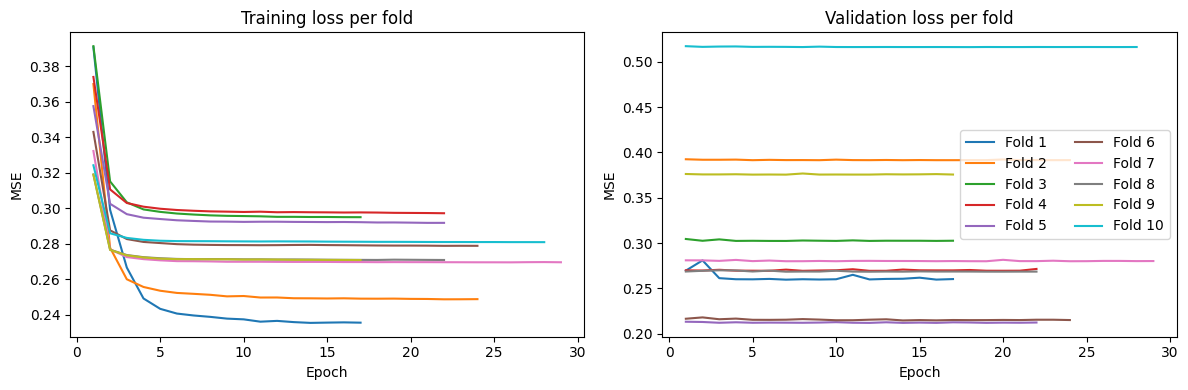

In [26]:
curve_df = pd.concat([pd.DataFrame(h['curve']) for h in best_cv_histories], ignore_index=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for fold, grp in curve_df.groupby('fold'):
    axes[0].plot(grp['epoch'], grp['train_loss'], label=f'Fold {fold}')
    axes[1].plot(grp['epoch'], grp['val_loss'], label=f'Fold {fold}')

axes[0].set_title('Training loss per fold')
axes[1].set_title('Validation loss per fold')
for ax in axes:
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE')
axes[1].legend(ncol=2)
plt.tight_layout()
fig.savefig(ARTIFACT_DIR / 'cv_loss_curves.png')


### Cross-validation diagnostics
Purged and embargoed splits combined with per-symbol scaling can change the optimization dynamics, so we track fold-level losses and Sharpe ratios to quickly spot unstable windows. The plot below summarizes the best metrics from each fold.


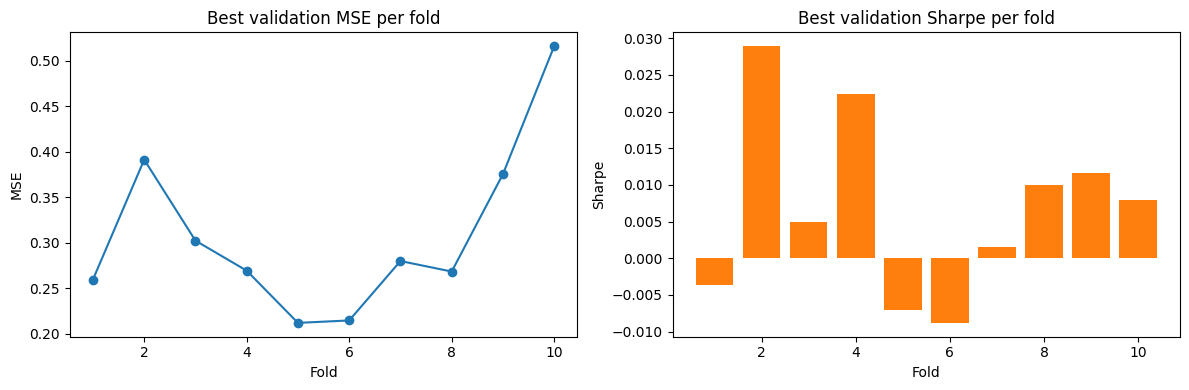

In [27]:
if best_cv_histories:
    cv_df = pd.DataFrame(best_cv_histories)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(cv_df['fold'], cv_df['best_val_mse'], marker='o', color='#1f77b4')
    axes[0].set_title('Best validation MSE per fold')
    axes[0].set_xlabel('Fold')
    axes[0].set_ylabel('MSE')
    axes[1].bar(cv_df['fold'], cv_df['best_val_sharpe'], color='#ff7f0e')
    axes[1].set_title('Best validation Sharpe per fold')
    axes[1].set_xlabel('Fold')
    axes[1].set_ylabel('Sharpe')
    plt.tight_layout()
    fig.savefig(ARTIFACT_DIR / 'cv_best_metrics.png')
else:
    print('best_cv_histories is empty – run the grid search routine first.')


## Final training on full training window

In [ ]:
# as in HYPER_PARAM_GRID above, just take medium_depth out
config_grid = {
    'medium_depth': {
        'model_kwargs': {'d_model': 192, 'nhead': 6, 'num_layers': 3,
                         'ff_dim': 512, 'dropout': 0.35,
                         'categorical_emb_dim': 12, 'symbol_emb_dim': 12},
        'train_kwargs': {'epochs': 80, 'lr': 3e-4, 'weight_decay': 5e-4,
                         'patience': 10, 'warmup_epochs': 8, 'batch_size': 192}
    },
}


In [29]:
# --- force medium_depth config (skip prefix CV) ---
selected_config = 'medium_depth'
best_model_kwargs = config_grid[selected_config]['model_kwargs']
best_train_kwargs = config_grid[selected_config]['train_kwargs']
best_config_name = selected_config

VALID_SPLIT = int(len(train_X_seq) * 0.9)
train_ds = TensorDataset(
    torch.from_numpy(train_X_seq[:VALID_SPLIT]),
    torch.from_numpy(train_emb_seq[:VALID_SPLIT]),
    torch.from_numpy(train_symbol_ids[:VALID_SPLIT]),
    torch.from_numpy(train_y_seq[:VALID_SPLIT]),
    torch.from_numpy(train_y_seq_raw[:VALID_SPLIT])
)
val_ds = TensorDataset(
    torch.from_numpy(train_X_seq[VALID_SPLIT:]),
    torch.from_numpy(train_emb_seq[VALID_SPLIT:]),
    torch.from_numpy(train_symbol_ids[VALID_SPLIT:]),
    torch.from_numpy(train_y_seq[VALID_SPLIT:]),
    torch.from_numpy(train_y_seq_raw[VALID_SPLIT:])
)

final_batch_size = best_train_kwargs.get('batch_size', BATCH_SIZE)
train_loader = DataLoader(train_ds, batch_size=final_batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=final_batch_size, shuffle=False)

criterion = nn.SmoothL1Loss(beta=HUBER_DELTA)
final_model = ReturnTransformer(
    len(feature_cols),
    NUM_SYMBOLS,
    embedding_cardinalities=embedding_cardinalities,
    **best_model_kwargs
).to(DEVICE)

final_lr = best_train_kwargs.get('lr', 4e-4)
final_weight_decay = best_train_kwargs.get('weight_decay', 7.5e-4)
final_epochs = best_train_kwargs.get('epochs', 60)
final_patience = best_train_kwargs.get('patience', 8)
final_warmup = best_train_kwargs.get('warmup_epochs', DEFAULT_WARMUP_EPOCHS)
optimizer = torch.optim.AdamW(final_model.parameters(), lr=final_lr, weight_decay=final_weight_decay)
scheduler = WarmupCosineScheduler(optimizer, final_warmup, final_epochs, min_lr=1e-5)

best_state, best_val, best_metrics = None, math.inf, None
patience_ctr = 0

log_message(
    f"Final training uses config {best_config_name} | lr={final_lr}, wd={final_weight_decay}, "
    f"batch={final_batch_size}, epochs={final_epochs}, warmup={final_warmup}"
)

for epoch in range(1, final_epochs + 1):
    train_loss = train_epoch(final_model, train_loader, optimizer, criterion)
    val_loss = eval_epoch(final_model, val_loader, criterion)
    val_metrics = evaluate_loader_metrics(final_model, val_loader, y_scaler)
    log_message(
        f"Final | Epoch {epoch} | train {train_loss:.5f} | val {val_loss:.5f} | "
        f"val_SR {val_metrics['sharpe']:.4f} | rmse {val_metrics['rmse']:.5f} | "
        f"lr {optimizer.param_groups[0]['lr']:.2e}"
    )
    scheduler.step()

    improved = False
    if val_loss < best_val - 1e-6:
        improved = True
    elif abs(val_loss - best_val) <= 1e-6 and (
        val_metrics['sharpe'] > (best_metrics['sharpe'] if best_metrics else -math.inf) + 1e-4
    ):
        improved = True

    if improved:
        best_val = val_loss
        best_metrics = val_metrics
        best_state = copy.deepcopy(final_model.state_dict())
        patience_ctr = 0
    else:
        patience_ctr += 1
        if patience_ctr >= final_patience:
            log_message('Early stopping triggered on final model')
            break

if best_state is None:
    raise RuntimeError('Final model never improved; inspect training logs for issues.')

final_model.load_state_dict(best_state)
torch.save(final_model.state_dict(), ARTIFACT_DIR / 'final_model.pt')
log_message(
    f"Best final val Sharpe: {best_metrics['sharpe']:.4f}, RMSE: {best_metrics['rmse']:.5f}"
)


/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[2025-11-10T00:15:56.944758+00:00] Final training uses config medium_depth | lr=0.0003, wd=0.0005, batch=192, epochs=80, warmup=8
[2025-11-10T00:16:19.281807+00:00] Final | Epoch 1 | train 0.32610 | val 0.49089 | val_SR 0.0004 | rmse 0.00372 | lr 3.75e-05
[2025-11-10T00:16:40.958663+00:00] Final | Epoch 2 | train 0.28634 | val 0.49090 | val_SR 0.0047 | rmse 0.00372 | lr 7.50e-05
[2025-11-10T00:17:03.466207+00:00] Final | Epoch 3 | train 0.28336 | val 0.49151 | val_SR 0.0037 | rmse 0.00372 | lr 1.12e-04
[2025-11-10T00:17:25.710024+00:00] Final | Epoch 4 | train 0.28237 | val 0.49051 | val_SR -0.0087 | rmse 0.00372 | lr 1.50e-04
[2025-11-10T00:17:48.425649+00:00] Final | Epoch 5 | train 0.28172 | val 0.49054 | val_SR -0.0060 | rmse 0.00372 | lr 1.87e-04
[2025-11-10T00:18:10.922807+00:00] Final | Epoch 6 | train 0.28144 | val 0.49051 | val_SR -0.0017 | rmse 0.00372 | lr 2.25e-04
[2025-11-10T00:18:33.967135+00:00] Final | Epoch 7 | train 0.28153 | val 0.49056 | val_SR -0.0072 | rmse 0.0037

## Sharpe evaluation

In [30]:
def _predict_with_model(model, X_seq, X_emb_seq, symbol_ids):
    preds_scaled = predict_batches(model, X_seq, X_emb_seq, symbol_ids)
    preds_raw = y_scaler.inverse_transform(preds_scaled.reshape(-1, 1)).ravel()
    positions = map_to_position(preds_raw)
    return {
        'pred_scaled': preds_scaled,
        'pred_raw': preds_raw,
        'positions': positions
    }


def _prepare_prediction_df(pred_dict, meta_dt, symbol_ids, actual_returns):
    return pd.DataFrame({
        'datetime': pd.to_datetime(meta_dt),
        'symbol_id': symbol_ids,
        'symbol': [symbol_list[sid] for sid in symbol_ids],
        'pred_return': pred_dict['pred_raw'],
        'position': pred_dict['positions'],
        'actual_return': actual_returns
    })

final_model.eval()
train_preds = _predict_with_model(final_model, train_X_seq, train_emb_seq, train_symbol_ids)
train_metrics = compute_regression_metrics(train_preds['pred_raw'], train_y_seq_raw)
train_pred_df = _prepare_prediction_df(train_preds, train_meta_dt, train_symbol_ids, train_y_seq_raw)
print(f"Train Sharpe (final model): {train_metrics['sharpe']:.6f}")

test_preds = _predict_with_model(final_model, test_X_seq, test_emb_seq, test_symbol_ids)
test_metrics = compute_regression_metrics(test_preds['pred_raw'], test_y_seq_raw)
test_pred_df = _prepare_prediction_df(test_preds, test_meta_dt, test_symbol_ids, test_y_seq_raw)
print(f"Test Sharpe  (final model): {test_metrics['sharpe']:.6f}")


Train Sharpe (final model): 0.004460
Test Sharpe  (final model): 0.002094


# 30min rolling backtest based on final-model predictions 


In [ ]:
test_meta_dt_unique = np.unique(test_meta_dt)

In [37]:
# --- 30min rolling backtest with true rolling window inference ---
ROLLING_WINDOW_MINUTES = 30
TOP_K = 5
has_embeddings = len(embedding_feature_cols) > 0

df_backtest = df_processed.set_index('datetime').sort_index()
test_minutes = np.sort(test_df['datetime'].unique())

final_model.eval()
rolling_rows = []

for current_dt in tqdm(test_minutes, desc='Rolling inference'):
    if current_dt not in df_backtest.index:
        continue

    future_rows = df_backtest.loc[current_dt]
    if isinstance(future_rows, pd.Series):
        future_rows = future_rows.to_frame().T
    future_rows = future_rows.set_index('symbol')

    start_dt = current_dt - np.timedelta64(ROLLING_WINDOW_MINUTES, 'm')
    window = df_backtest.loc[start_dt:current_dt - np.timedelta64(1, 'm')]
    if window.empty:
        continue

    seq_numeric, seq_emb, seq_symbol_ids, meta = [], [], [], []
    for symbol, group in window.groupby('symbol'):
        group = group.sort_index()
        if len(group) < SEQ_LEN or symbol not in future_rows.index:
            continue

        seq_numeric.append(group[feature_cols].tail(SEQ_LEN).values.astype(np.float32))
        if has_embeddings:
            seq_emb.append(group[embedding_feature_cols].tail(SEQ_LEN).values.astype(np.int64))
        seq_symbol_ids.append(int(group['symbol_id'].iloc[-1]))
        meta.append({
            'symbol': symbol,
            'actual_log_return': float(future_rows.loc[symbol, 'y_target'])
        })

    if not seq_numeric:
        continue

    X_num = torch.from_numpy(np.stack(seq_numeric)).to(DEVICE)
    cat_tensor = None
    if has_embeddings:
        cat_tensor = torch.from_numpy(np.stack(seq_emb)).to(DEVICE)
    sym_tensor = torch.from_numpy(np.array(seq_symbol_ids, dtype=np.int64)).to(DEVICE)

    with torch.no_grad():
        pred_scaled = final_model(X_num, sym_tensor, cat_tensor).cpu().numpy().ravel()
    pred_raw = y_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()
    positions = map_to_position(pred_raw)

    minute_df = pd.DataFrame({
        'symbol': [m['symbol'] for m in meta],
        'actual_log_return': [m['actual_log_return'] for m in meta],
        'predicted_return': pred_raw,
        'position': positions
    })
    minute_df['abs_position'] = minute_df['position'].abs()
    minute_df = minute_df.nlargest(TOP_K, 'abs_position')
    total_abs = minute_df['abs_position'].sum()
    if total_abs == 0:
        continue

    minute_df['weight_relative'] = minute_df['position'] / total_abs
    minute_df['weight_sign'] = np.sign(minute_df['weight_relative'])
    minute_df['datetime'] = current_dt
    rolling_rows.append(
        minute_df[['datetime', 'symbol', 'predicted_return', 'position',
                   'actual_log_return', 'weight_relative', 'weight_sign']]
    )

backtest_df = pd.concat(rolling_rows, ignore_index=True)
backtest_path = Path('output/transformer_backtest_results_Huber.csv')
backtest_path.parent.mkdir(parents=True, exist_ok=True)
backtest_df.to_csv(backtest_path, index=False)

print(backtest_df.head())
print(f'Backtest rows: {len(backtest_df)} | Saved to {backtest_path}')


Rolling inference:   0%|          | 0/21660 [00:00<?, ?it/s]

             datetime symbol  predicted_return  position  actual_log_return  \
0 2025-04-29 15:59:00    AMD          0.000019  0.019483          -0.006581   
1 2025-04-29 15:59:00     MU          0.000018  0.018026          -0.019444   
2 2025-04-29 15:59:00   NVDA          0.000016  0.015607          -0.025525   
3 2025-04-29 15:59:00   AVGO          0.000014  0.013713          -0.008008   
4 2025-04-29 15:59:00   AMAT          0.000010  0.009881          -0.014007   

   weight_relative  weight_sign  
0         0.253978          1.0  
1         0.234991          1.0  
2         0.203454          1.0  
3         0.178765          1.0  
4         0.128811          1.0  
Backtest rows: 91199 | Saved to output/transformer_backtest_results_Huber.csv


In [44]:
backtest_df.head(15)

,datetime,symbol,predicted_return,position,actual_log_return,weight_relative,weight_sign,residual
0,2025-04-29 15:59:00,AMD,0.000019,0.019483,-0.006581,0.253978,1.0,0.006601
1,2025-04-29 15:59:00,MU,0.000018,0.018026,-0.019444,0.234991,1.0,0.019462
2,2025-04-29 15:59:00,NVDA,0.000016,0.015607,-0.025525,0.203454,1.0,0.025541
3,2025-04-29 15:59:00,AVGO,0.000014,0.013713,-0.008008,0.178765,1.0,0.008022
4,2025-04-29 15:59:00,AMAT,0.000010,0.009881,-0.014007,0.128811,1.0,0.014017
5,2025-04-30 13:20:00,AVGO,-0.000009,-0.008525,0.001138,-0.345125,-1.0,-0.001146
6,2025-04-30 13:20:00,AMAT,-0.000007,-0.006772,-0.000238,-0.274170,-1.0,0.000231
7,2025-04-30 13:20:00,AMD,0.000005,0.004810,-0.000315,0.194731,1.0,0.000319
8,2025-04-30 13:20:00,MU,-0.000003,-0.002962,-0.000399,-0.119931,-1.0,0.000396
9,2025-04-30 13:20:00,NVDA,0.000002,0.001631,0.000044,0.066043,1.0,-0.000043


### Strategy visualization
The following chart aggregates the rank-weighted positions into a cumulative log-return curve so we can gauge stability beyond a single Sharpe statistic.


Cumulative PnL figure saved to cumulative_pnl.png


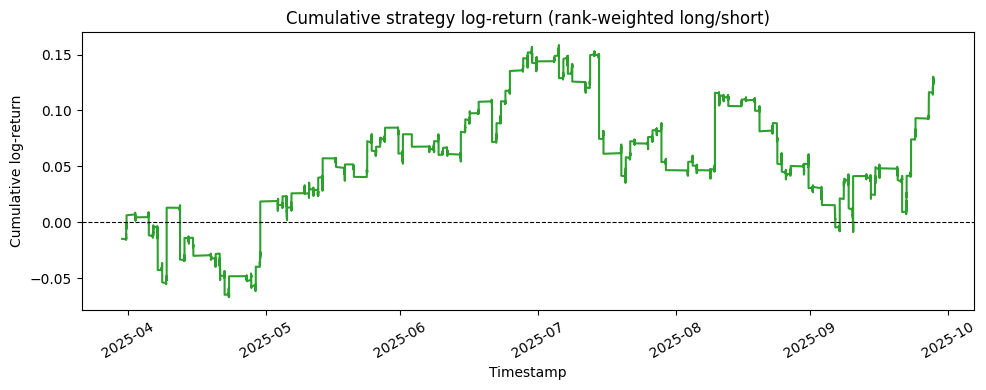

In [39]:

if 'backtest_df' in globals() and not backtest_df.empty:
    pnl_series = backtest_df['weight_relative'] * backtest_df['actual_log_return']
    pnl_by_minute = pnl_series.groupby(backtest_df['datetime']).sum()
    cumulative = pnl_by_minute.cumsum()
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(cumulative.index, cumulative.values, color='#2ca02c')
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    ax.set_title('Cumulative strategy log-return (rank-weighted long/short)')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Cumulative log-return')
    plt.xticks(rotation=30)
    plt.tight_layout()
    # save cumulative PnL figure
    CUMULATIVE_PNL_PATH =  'cumulative_pnl.png'
    fig.savefig(CUMULATIVE_PNL_PATH)
    print(f"Cumulative PnL figure saved to {CUMULATIVE_PNL_PATH}")
else:
    print('No backtest dataframe available for visualization.')


# Visualizations

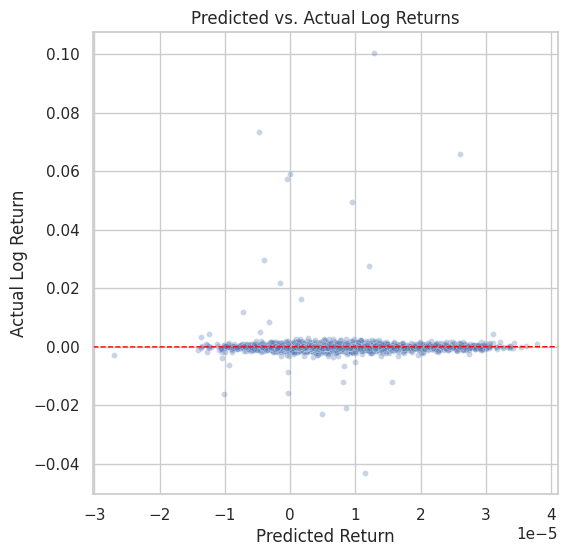

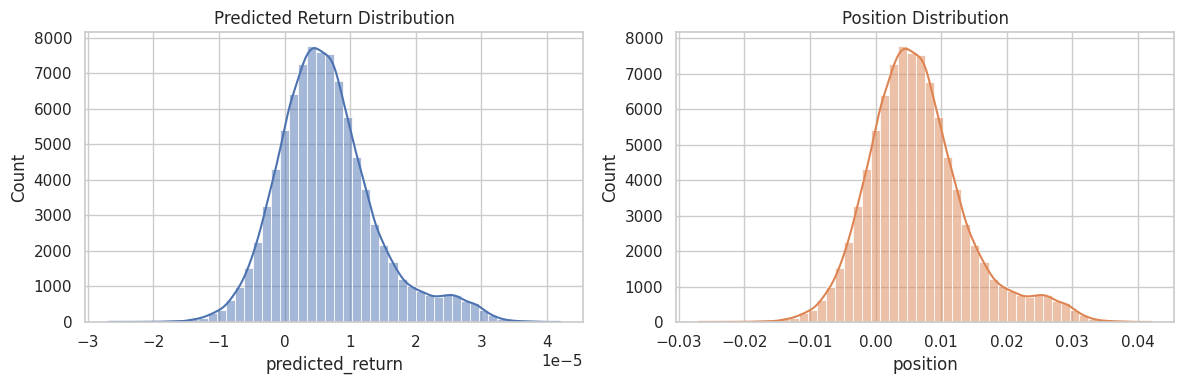

/tmp/ipykernel_1877/3523519666.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=decile_perf, x='decile', y='actual_log_return', palette='crest', ax=ax)


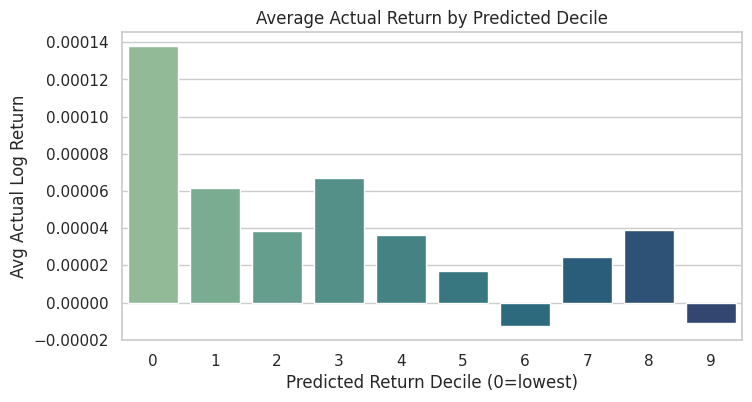

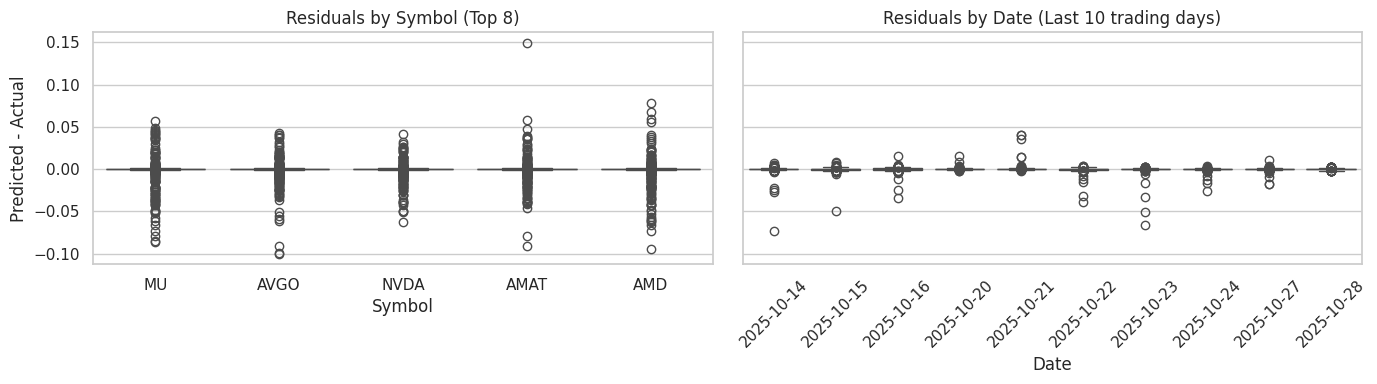

In [ ]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')

# --- 读取回测结果 ---
backtest_path = Path('output/transformer_backtest_results_Huber.csv')
backtest_df = pd.read_csv(backtest_path, parse_dates=['datetime'])
backtest_df['residual'] = backtest_df['predicted_return'] - backtest_df['actual_log_return']

# 1) 预测 vs. 实际散点图
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(
    data=backtest_df.sample(min(len(backtest_df), 5000), random_state=42),
    x='predicted_return', y='actual_log_return',
    alpha=0.3, s=18, ax=ax
)
ax.axline((0, 0), slope=1, color='red', linestyle='--', linewidth=1)
ax.set_title('Predicted vs. Actual Log Returns')
ax.set_xlabel('Predicted Return')
ax.set_ylabel('Actual Log Return')
plt.show()
# save figure
fig.savefig(ARTIFACT_DIR / 'predicted_vs_actual_scatter.png')

# 2) 预测 / 仓位分布直方图
# 对 predicted_return、map_to_position 后的 position 分布画直方图或 KDE，了解模型输出的幅度是否集中在零附近、有没有明显偏向某方向。
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(backtest_df['predicted_return'], bins=50, kde=True, ax=axes[0], color='#4c72b0')
axes[0].set_title('Predicted Return Distribution')
sns.histplot(backtest_df['position'], bins=50, kde=True, ax=axes[1], color='#dd8452')
axes[1].set_title('Position Distribution')
plt.tight_layout()
plt.show()
# save figure
fig.savefig(ARTIFACT_DIR / 'predicted_position_distribution.png')

# 3) 分位收益曲线（十分位）
# 分位收益曲线：把预测值按分位分组（如 top/bottom deciles），计算各组的平均实际收益，画条形图；可快速衡量信号排序能力。
deciles = pd.qcut(backtest_df['predicted_return'], q=10, labels=False, duplicates='drop')
decile_perf = (
    backtest_df
    .assign(decile=deciles)
    .groupby('decile', observed=True)['actual_log_return']
    .mean()
    .reset_index()
)
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(data=decile_perf, x='decile', y='actual_log_return', palette='crest', ax=ax)
ax.set_title('Average Actual Return by Predicted Decile')
ax.set_xlabel('Predicted Return Decile (0=lowest)')
ax.set_ylabel('Avg Actual Log Return')
plt.show()
# save figure
fig.savefig(ARTIFACT_DIR / 'decile_performance.png')


# 5) 残差箱线图（按股票 / 日期）
# 预测残差随时间/符号的箱线图：(predicted_return - actual_log_return) 按日期或股票分组，画箱线/小提琴图，帮助判断是否对某些股票偏置明显。
top_symbols = backtest_df['symbol'].value_counts().head(8).index
recent_dates = (
    backtest_df['datetime'].dt.date
    .sort_values()
    .unique()[-10:]  # 最近 10 个交易日
)

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
sns.boxplot(
    data=backtest_df[backtest_df['symbol'].isin(top_symbols)],
    x='symbol', y='residual', order=top_symbols, ax=axes[0]
)
axes[0].set_title('Residuals by Symbol (Top 8)')
axes[0].set_xlabel('Symbol')
axes[0].set_ylabel('Predicted - Actual')

sns.boxplot(
    data=backtest_df[backtest_df['datetime'].dt.date.isin(recent_dates)],
    x=backtest_df['datetime'].dt.date, y='residual', order=recent_dates, ax=axes[1]
)
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_title('Residuals by Date (Last 10 trading days)')
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.show()
# save figure
fig.savefig(ARTIFACT_DIR / 'residuals_boxplots.png')

